# Models

## LDA

In [1]:
#Importing relevant packages 

import numpy as np
import pandas as pd
from datetime import datetime #To check start and end time when running code
from tqdm import tqdm #This is for creating progress bars.
import logging #This is to provide logging of information when running the LDA
import sys #This is to disable logging when it's no longer needed
import pickle #To store and open previously saved machine learning models 

#Importing NLTK and NLP packages
import nltk
from nltk import word_tokenize, pos_tag
import string
import re
from collections import defaultdict

#Importing packages for data visualization 
import matplotlib.pyplot as plt
import seaborn as sns

#Importing packages for LDA
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaMulticore

### 1. Preparing data for Topic Modelling

In [2]:
# opening the df
df = pd.read_csv('df_all_processed.csv')

In [10]:
# df = df.drop('Unnamed: 0', axis=1)
# df.head

In [3]:
df.head()

,Unnamed: 0,URL,Datetime,Title,Text,Affiliation,processed_text,processed_filtered_text,lemma_text
0,9908,world/2021/aug/03/belarus-exile-group-leader-v...,2021-08-03,Belarus exile group leader Vitaly Shishov foun...,The head of a Kyiv-based non-profit organisati...,Guardian,head Kyiv-based non-profit organisation helps ...,head kyiv based non profit organisation helps ...,head kyiv base non profit organisation help be...
1,9909,world/2021/aug/03/uk-on-your-side-boris-johnso...,2021-08-03,"UK is on your side, Boris Johnson tells Belaru...",The UK is on the side of Belarusian opposition...,Guardian,UK side Belarusian opposition leaders trying b...,uk side belarusian opposition leaders trying b...,uk side belarusian opposition leader try bring...
2,9907,world/2021/aug/03/anger-in-turkey-grows-over-g...,2021-08-03,Anger in Turkey grows over government’s handli...,People across Turkey are looking for answers a...,Guardian,People across Turkey looking answers summer wi...,people across turkey looking answers summer wi...,people across turkey look answer summer wildfi...
3,9911,world/2021/aug/07/greek-firefighter-killed-ath...,2021-08-07,Greek firefighter killed and 20 injured as fir...,A volunteer firefighter has been killed in a b...,Guardian,volunteer firefighter killed blaze threatening...,volunteer firefighter killed blaze threatening...,volunteer firefighter kill blaze threaten gree...
4,9910,world/2021/aug/07/belarus-danger-belarusian-di...,2021-08-07,Belarus exiles fear the long arm of the vengef...,It is a fraught and dangerous time to be a Bel...,Guardian,fraught dangerous time Belarusian activist dis...,fraught dangerous time belarusian activist dis...,fraught dangerous time belarusian activist dis...


In [4]:
# Define a tokenizer function using word_tokenize
def custom_tokenizer(text):
    # Use word_tokenize to tokenize the input text
    tokens = word_tokenize(text)
    return tokens

tqdm.pandas() #Creates a progress bar. Use progress_apply instead of apply.

In [5]:
# Creating a column of unigrams from the lemmatized text
df['unigrams'] = df['lemma_text'].progress_apply(lambda x: custom_tokenizer(x))

df['lemma_text'] = df['lemma_text'].astype(str)

100%|████████████████████████████████████| 14223/14223 [01:07<00:00, 209.45it/s]


In [6]:
# Removing the following words from unigrams
words_to_remove = ['’_s', 's', '–', 'u', '’_t', 't' ,'’', 'say']


# Function to remove specified words from a text
def remove_words(word_list):
    filtered_words = [word for word in word_list if word not in words_to_remove]
    return filtered_words

# Apply the function to the 'lemma_text' column
df['unigrams'] = df['unigrams'].apply(remove_words)

# Apply the function to the 'lemma_text' column for BB DataFrame
df['unigrams'] = df['unigrams'].apply(remove_words)

In [7]:
def bigrams(doc):
    bigrams = []  # Empty list to save the bigrams
    
    if isinstance(doc, list):  # Check if doc is a list
        for bigram in list(nltk.bigrams(doc)):
            bigrams.append("_".join(bigram))
    
    return bigrams


#Creating a column with bigrams
df['bigrams'] = df.unigrams.progress_apply(lambda x: bigrams(x))

100%|███████████████████████████████████| 14223/14223 [00:03<00:00, 4557.37it/s]


In [8]:
df['tokens'] = df.unigrams+df.bigrams

### 2. Creating a corpus object

In [9]:
# Create a id2word dictionary

# Insert the column where you saved unigram and bigram tokens between the parentheses
id2word = Dictionary(df['tokens']) 

# Viewing how many words are in our vocabulary
print(len(id2word))

2296502


very conservative is 100, and go up to 1% of words. Methods literature to show different pruning and thresholds and
we're still getting the same output. 1% is usually the standard.

In [10]:
# Removing very frequent and infrequent words
id2word.filter_extremes(no_below=100, no_above=.999, keep_n = None)
print(len(id2word))

10304


In [11]:
# creating the corpus
corpus = [id2word.doc2bow(doc) for doc in df['tokens']]

### 3. Topic modelling

The passes and iterations should be high enough for the model to converge. In the pre-trained model, passes = 100 and iterations = 1000.

Minimum_probability: This filters out all probabilities less than the given number. In the pre-trained model, minimum_probability = 0.000001

In [28]:
# Instantiating a logger to get information on the progress of the LDA
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Running the LDA with 20 topics 
lda_model = LdaMulticore(corpus=corpus, num_topics=20, id2word=id2word, passes = 100, iterations = 1000)

2023-12-20 13:51:00,929 : INFO : using symmetric alpha at 0.05
2023-12-20 13:51:00,936 : INFO : using symmetric eta at 0.05
2023-12-20 13:51:00,939 : INFO : using serial LDA version on this node
2023-12-20 13:51:00,964 : INFO : running online LDA training, 20 topics, 100 passes over the supplied corpus of 14223 documents, updating every 14000 documents, evaluating every ~14223 documents, iterating 1000x with a convergence threshold of 0.001000
2023-12-20 13:51:00,966 : INFO : training LDA model using 7 processes
2023-12-20 13:51:11,911 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size 1
2023-12-20 13:51:12,131 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 13:51:12,357 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/14223, outstanding queue size 3
2023-12-20 13:51:12,556 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/14223,

2023-12-20 13:57:00,467 : INFO : PROGRESS: pass 3, dispatched chunk #6 = documents up to #14000/14223, outstanding queue size 7
2023-12-20 13:57:00,469 : INFO : PROGRESS: pass 3, dispatched chunk #7 = documents up to #14223/14223, outstanding queue size 8
2023-12-20 13:57:52,689 : INFO : topic #10 (0.050): 0.011*"trump" + 0.010*"biden" + 0.009*"house" + 0.008*"republican" + 0.006*"president" + 0.005*"election" + 0.005*"state" + 0.004*"vote" + 0.004*"new" + 0.004*"joe"
2023-12-20 13:57:52,702 : INFO : topic #17 (0.050): 0.011*"china" + 0.007*"covid" + 0.006*"taiwan" + 0.006*"people" + 0.006*"chinese" + 0.005*"country" + 0.005*"report" + 0.005*"government" + 0.004*"new" + 0.004*"year"
2023-12-20 13:57:52,704 : INFO : topic #19 (0.050): 0.016*"russian" + 0.014*"ukraine" + 0.009*"ukrainian" + 0.009*"russia" + 0.007*"force" + 0.007*"war" + 0.005*"city" + 0.004*"military" + 0.004*"people" + 0.004*"kyiv"
2023-12-20 13:57:52,706 : INFO : topic #18 (0.050): 0.018*"ukraine" + 0.010*"russia" + 0.

2023-12-20 14:00:04,838 : INFO : topic diff=0.192055, rho=0.266203
2023-12-20 14:00:05,582 : INFO : -7.792 per-word bound, 221.6 perplexity estimate based on a held-out corpus of 223 documents with 97406 words
2023-12-20 14:00:05,592 : INFO : PROGRESS: pass 7, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size 1
2023-12-20 14:00:05,843 : INFO : PROGRESS: pass 7, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 14:00:06,086 : INFO : PROGRESS: pass 7, dispatched chunk #2 = documents up to #6000/14223, outstanding queue size 3
2023-12-20 14:00:06,371 : INFO : PROGRESS: pass 7, dispatched chunk #3 = documents up to #8000/14223, outstanding queue size 4
2023-12-20 14:00:06,685 : INFO : PROGRESS: pass 7, dispatched chunk #4 = documents up to #10000/14223, outstanding queue size 5
2023-12-20 14:00:07,163 : INFO : PROGRESS: pass 7, dispatched chunk #5 = documents up to #12000/14223, outstanding queue size 6
2023-12-20 14:00:07,405 : 

2023-12-20 14:03:21,245 : INFO : topic #19 (0.050): 0.019*"russian" + 0.015*"ukraine" + 0.013*"ukrainian" + 0.009*"russia" + 0.009*"force" + 0.008*"city" + 0.007*"war" + 0.005*"kyiv" + 0.005*"military" + 0.004*"region"
2023-12-20 14:03:21,248 : INFO : topic #4 (0.050): 0.019*"russian" + 0.014*"russia" + 0.014*"sanction" + 0.008*"uk" + 0.007*"company" + 0.007*"putin" + 0.006*"government" + 0.005*"ukraine" + 0.005*"country" + 0.004*"include"
2023-12-20 14:03:21,249 : INFO : topic #14 (0.050): 0.013*"russian" + 0.010*"russia" + 0.009*"ukraine" + 0.005*"year" + 0.005*"state" + 0.005*"war" + 0.004*"use" + 0.004*"report" + 0.004*"crime" + 0.004*"ukrainian"
2023-12-20 14:03:21,250 : INFO : topic #16 (0.050): 0.020*"oil" + 0.015*"price" + 0.013*"biden" + 0.008*"saudi" + 0.008*"energy" + 0.006*"president" + 0.006*"gas" + 0.006*"year" + 0.005*"percent" + 0.005*"russia"
2023-12-20 14:03:21,250 : INFO : topic #6 (0.050): 0.010*"photograph" + 0.007*"climate" + 0.007*"iran" + 0.006*"year" + 0.006*"s

2023-12-20 14:05:28,053 : INFO : PROGRESS: pass 14, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size 1
2023-12-20 14:05:28,299 : INFO : PROGRESS: pass 14, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 14:05:28,569 : INFO : PROGRESS: pass 14, dispatched chunk #2 = documents up to #6000/14223, outstanding queue size 3
2023-12-20 14:05:28,878 : INFO : PROGRESS: pass 14, dispatched chunk #3 = documents up to #8000/14223, outstanding queue size 4
2023-12-20 14:05:29,325 : INFO : PROGRESS: pass 14, dispatched chunk #4 = documents up to #10000/14223, outstanding queue size 5
2023-12-20 14:05:29,794 : INFO : PROGRESS: pass 14, dispatched chunk #5 = documents up to #12000/14223, outstanding queue size 6
2023-12-20 14:05:30,022 : INFO : PROGRESS: pass 14, dispatched chunk #6 = documents up to #14000/14223, outstanding queue size 7
2023-12-20 14:05:30,034 : INFO : PROGRESS: pass 14, dispatched chunk #7 = documents up to #14223/1422

2023-12-20 14:08:12,652 : INFO : topic #19 (0.050): 0.021*"russian" + 0.016*"ukraine" + 0.015*"ukrainian" + 0.010*"russia" + 0.010*"force" + 0.009*"city" + 0.007*"war" + 0.006*"kyiv" + 0.005*"military" + 0.004*"region"
2023-12-20 14:08:12,653 : INFO : topic #0 (0.050): 0.024*"ukraine" + 0.017*"russian" + 0.016*"russia" + 0.011*"ukrainian" + 0.006*"report" + 0.006*"attack" + 0.005*"force" + 0.005*"defence" + 0.005*"kyiv" + 0.005*"region"
2023-12-20 14:08:12,653 : INFO : topic #15 (0.050): 0.026*"ukraine" + 0.015*"church" + 0.014*"ukrainian" + 0.011*"orthodox" + 0.009*"russian" + 0.008*"war" + 0.007*"russia" + 0.006*"orthodox_church" + 0.006*"year" + 0.005*"pope"
2023-12-20 14:08:12,654 : INFO : topic #1 (0.050): 0.007*"year" + 0.007*"it" + 0.006*"people" + 0.005*"one" + 0.005*"party" + 0.004*"time" + 0.004*"go" + 0.004*"would" + 0.004*"government" + 0.004*"make"
2023-12-20 14:08:12,655 : INFO : topic diff=0.214409, rho=0.199555
2023-12-20 14:08:13,359 : INFO : -7.709 per-word bound, 209

2023-12-20 14:10:19,172 : INFO : PROGRESS: pass 21, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 14:10:19,447 : INFO : PROGRESS: pass 21, dispatched chunk #2 = documents up to #6000/14223, outstanding queue size 3
2023-12-20 14:10:19,768 : INFO : PROGRESS: pass 21, dispatched chunk #3 = documents up to #8000/14223, outstanding queue size 4
2023-12-20 14:10:20,115 : INFO : PROGRESS: pass 21, dispatched chunk #4 = documents up to #10000/14223, outstanding queue size 5
2023-12-20 14:10:20,656 : INFO : PROGRESS: pass 21, dispatched chunk #5 = documents up to #12000/14223, outstanding queue size 6
2023-12-20 14:10:20,887 : INFO : PROGRESS: pass 21, dispatched chunk #6 = documents up to #14000/14223, outstanding queue size 7
2023-12-20 14:10:21,126 : INFO : PROGRESS: pass 21, dispatched chunk #7 = documents up to #14223/14223, outstanding queue size 8
2023-12-20 14:10:58,647 : INFO : topic #0 (0.050): 0.024*"ukraine" + 0.017*"russian" + 0.016*"russia

2023-12-20 14:13:15,471 : INFO : topic #11 (0.050): 0.019*"china" + 0.016*"russia" + 0.010*"ukraine" + 0.009*"president" + 0.008*"chinese" + 0.008*"country" + 0.007*"state" + 0.007*"putin" + 0.006*"foreign" + 0.006*"war"
2023-12-20 14:13:15,472 : INFO : topic #12 (0.050): 0.014*"ukraine" + 0.012*"eu" + 0.012*"country" + 0.010*"nato" + 0.009*"european" + 0.007*"ukrainian" + 0.006*"food" + 0.006*"minister" + 0.006*"finland" + 0.006*"sweden"
2023-12-20 14:13:15,473 : INFO : topic #0 (0.050): 0.024*"ukraine" + 0.017*"russian" + 0.016*"russia" + 0.011*"ukrainian" + 0.007*"report" + 0.006*"attack" + 0.006*"defence" + 0.006*"kyiv" + 0.006*"force" + 0.005*"region"
2023-12-20 14:13:15,473 : INFO : topic diff=0.200538, rho=0.176470
2023-12-20 14:13:16,152 : INFO : -7.691 per-word bound, 206.6 perplexity estimate based on a held-out corpus of 223 documents with 97406 words
2023-12-20 14:13:16,187 : INFO : PROGRESS: pass 25, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size

2023-12-20 14:15:33,859 : INFO : PROGRESS: pass 28, dispatched chunk #3 = documents up to #8000/14223, outstanding queue size 4
2023-12-20 14:15:34,492 : INFO : PROGRESS: pass 28, dispatched chunk #4 = documents up to #10000/14223, outstanding queue size 5
2023-12-20 14:15:35,063 : INFO : PROGRESS: pass 28, dispatched chunk #5 = documents up to #12000/14223, outstanding queue size 6
2023-12-20 14:15:35,462 : INFO : PROGRESS: pass 28, dispatched chunk #6 = documents up to #14000/14223, outstanding queue size 7
2023-12-20 14:15:35,932 : INFO : PROGRESS: pass 28, dispatched chunk #7 = documents up to #14223/14223, outstanding queue size 8
2023-12-20 14:16:19,971 : INFO : topic #11 (0.050): 0.020*"china" + 0.016*"russia" + 0.010*"ukraine" + 0.009*"president" + 0.008*"chinese" + 0.008*"country" + 0.007*"state" + 0.007*"putin" + 0.006*"foreign" + 0.006*"xi"
2023-12-20 14:16:19,975 : INFO : topic #14 (0.050): 0.016*"russian" + 0.012*"russia" + 0.007*"ukraine" + 0.007*"war" + 0.006*"crime" + 0

2023-12-20 14:18:32,149 : INFO : topic #5 (0.050): 0.023*"gas" + 0.017*"germany" + 0.014*"energy" + 0.012*"—" + 0.011*"german" + 0.010*"russia" + 0.010*"russian" + 0.009*"pipeline" + 0.008*"european" + 0.008*"country"
2023-12-20 14:18:32,150 : INFO : topic #19 (0.050): 0.023*"russian" + 0.017*"ukraine" + 0.016*"ukrainian" + 0.011*"force" + 0.010*"city" + 0.010*"russia" + 0.007*"war" + 0.007*"kyiv" + 0.005*"military" + 0.005*"soldier"
2023-12-20 14:18:32,151 : INFO : topic diff=0.162193, rho=0.159900
2023-12-20 14:18:32,767 : INFO : -7.681 per-word bound, 205.2 perplexity estimate based on a held-out corpus of 223 documents with 97406 words
2023-12-20 14:18:32,778 : INFO : PROGRESS: pass 32, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size 1
2023-12-20 14:18:33,028 : INFO : PROGRESS: pass 32, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 14:18:33,284 : INFO : PROGRESS: pass 32, dispatched chunk #2 = documents up to #6000/

2023-12-20 14:21:01,546 : INFO : PROGRESS: pass 35, dispatched chunk #5 = documents up to #12000/14223, outstanding queue size 6
2023-12-20 14:21:01,917 : INFO : PROGRESS: pass 35, dispatched chunk #6 = documents up to #14000/14223, outstanding queue size 7
2023-12-20 14:21:01,937 : INFO : PROGRESS: pass 35, dispatched chunk #7 = documents up to #14223/14223, outstanding queue size 8
2023-12-20 14:21:45,376 : INFO : topic #3 (0.050): 0.017*"wagner" + 0.015*"prigozhin" + 0.014*"military" + 0.010*"north" + 0.009*"korea" + 0.009*"russian" + 0.008*"russia" + 0.008*"group" + 0.008*"force" + 0.006*"north_korea"
2023-12-20 14:21:45,379 : INFO : topic #2 (0.050): 0.027*"ukraine" + 0.014*"russia" + 0.011*"putin" + 0.010*"war" + 0.009*"would" + 0.009*"president" + 0.008*"nato" + 0.008*"biden" + 0.007*"russian" + 0.006*"military"
2023-12-20 14:21:45,381 : INFO : topic #17 (0.050): 0.015*"covid" + 0.009*"people" + 0.008*"report" + 0.008*"china" + 0.008*"new" + 0.007*"taiwan" + 0.007*"country" + 0.

2023-12-20 14:23:57,044 : INFO : topic #14 (0.050): 0.016*"russian" + 0.013*"russia" + 0.007*"war" + 0.007*"crime" + 0.006*"ukraine" + 0.006*"year" + 0.005*"arrest" + 0.005*"state" + 0.005*"court" + 0.005*"medium"
2023-12-20 14:23:57,044 : INFO : topic diff=0.122772, rho=0.147264
2023-12-20 14:23:57,676 : INFO : -7.674 per-word bound, 204.3 perplexity estimate based on a held-out corpus of 223 documents with 97406 words
2023-12-20 14:23:57,686 : INFO : PROGRESS: pass 39, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size 1
2023-12-20 14:23:57,933 : INFO : PROGRESS: pass 39, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 14:23:58,232 : INFO : PROGRESS: pass 39, dispatched chunk #2 = documents up to #6000/14223, outstanding queue size 3
2023-12-20 14:23:58,565 : INFO : PROGRESS: pass 39, dispatched chunk #3 = documents up to #8000/14223, outstanding queue size 4
2023-12-20 14:23:59,100 : INFO : PROGRESS: pass 39, dispatched c

2023-12-20 14:26:15,153 : INFO : PROGRESS: pass 42, dispatched chunk #7 = documents up to #14223/14223, outstanding queue size 8
2023-12-20 14:26:54,640 : INFO : topic #19 (0.050): 0.024*"russian" + 0.017*"ukraine" + 0.017*"ukrainian" + 0.011*"city" + 0.011*"force" + 0.010*"russia" + 0.007*"war" + 0.007*"kyiv" + 0.006*"military" + 0.005*"soldier"
2023-12-20 14:26:54,643 : INFO : topic #5 (0.050): 0.024*"gas" + 0.018*"germany" + 0.014*"energy" + 0.012*"german" + 0.012*"—" + 0.010*"russia" + 0.010*"russian" + 0.009*"pipeline" + 0.008*"european" + 0.008*"country"
2023-12-20 14:26:54,644 : INFO : topic #1 (0.050): 0.007*"it" + 0.007*"year" + 0.006*"people" + 0.005*"one" + 0.005*"time" + 0.005*"party" + 0.005*"go" + 0.004*"make" + 0.004*"would" + 0.004*"government"
2023-12-20 14:26:54,645 : INFO : topic #9 (0.050): 0.021*"missile" + 0.016*"ukraine" + 0.013*"drone" + 0.012*"air" + 0.011*"defence" + 0.011*"russian" + 0.010*"—" + 0.009*"ukrainian" + 0.009*"weapon" + 0.009*"sea"
2023-12-20 14:2

2023-12-20 14:29:04,274 : INFO : topic diff=0.093040, rho=0.137216
2023-12-20 14:29:04,907 : INFO : -7.670 per-word bound, 203.7 perplexity estimate based on a held-out corpus of 223 documents with 97406 words
2023-12-20 14:29:04,918 : INFO : PROGRESS: pass 46, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size 1
2023-12-20 14:29:05,176 : INFO : PROGRESS: pass 46, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 14:29:05,446 : INFO : PROGRESS: pass 46, dispatched chunk #2 = documents up to #6000/14223, outstanding queue size 3
2023-12-20 14:29:05,734 : INFO : PROGRESS: pass 46, dispatched chunk #3 = documents up to #8000/14223, outstanding queue size 4
2023-12-20 14:29:05,757 : INFO : PROGRESS: pass 46, dispatched chunk #4 = documents up to #10000/14223, outstanding queue size 5
2023-12-20 14:29:06,670 : INFO : PROGRESS: pass 46, dispatched chunk #5 = documents up to #12000/14223, outstanding queue size 6
2023-12-20 14:29:06,

2023-12-20 14:32:10,534 : INFO : topic #3 (0.050): 0.019*"wagner" + 0.016*"prigozhin" + 0.014*"military" + 0.010*"north" + 0.009*"korea" + 0.009*"group" + 0.009*"russian" + 0.008*"force" + 0.008*"russia" + 0.006*"north_korea"
2023-12-20 14:32:10,538 : INFO : topic #15 (0.050): 0.029*"ukraine" + 0.019*"ukrainian" + 0.018*"war" + 0.011*"church" + 0.010*"people" + 0.009*"russian" + 0.008*"pope" + 0.008*"orthodox" + 0.007*"francis" + 0.006*"world"
2023-12-20 14:32:10,540 : INFO : topic #0 (0.050): 0.025*"ukraine" + 0.017*"russian" + 0.016*"russia" + 0.012*"ukrainian" + 0.007*"report" + 0.006*"attack" + 0.006*"defence" + 0.006*"kyiv" + 0.006*"force" + 0.006*"region"
2023-12-20 14:32:10,541 : INFO : topic #12 (0.050): 0.014*"eu" + 0.014*"ukraine" + 0.012*"country" + 0.012*"nato" + 0.010*"european" + 0.008*"minister" + 0.007*"finland" + 0.007*"sweden" + 0.006*"ukrainian" + 0.006*"would"
2023-12-20 14:32:10,542 : INFO : topic #6 (0.050): 0.011*"photograph" + 0.010*"climate" + 0.008*"year" + 0.

2023-12-20 14:34:21,297 : INFO : PROGRESS: pass 53, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size 1
2023-12-20 14:34:21,553 : INFO : PROGRESS: pass 53, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 14:34:21,830 : INFO : PROGRESS: pass 53, dispatched chunk #2 = documents up to #6000/14223, outstanding queue size 3
2023-12-20 14:34:22,149 : INFO : PROGRESS: pass 53, dispatched chunk #3 = documents up to #8000/14223, outstanding queue size 4
2023-12-20 14:34:22,689 : INFO : PROGRESS: pass 53, dispatched chunk #4 = documents up to #10000/14223, outstanding queue size 5
2023-12-20 14:34:23,182 : INFO : PROGRESS: pass 53, dispatched chunk #5 = documents up to #12000/14223, outstanding queue size 6
2023-12-20 14:34:23,665 : INFO : PROGRESS: pass 53, dispatched chunk #6 = documents up to #14000/14223, outstanding queue size 7
2023-12-20 14:34:23,712 : INFO : PROGRESS: pass 53, dispatched chunk #7 = documents up to #14223/1422

2023-12-20 14:37:28,232 : INFO : topic #8 (0.050): 0.032*"russian" + 0.020*"ukraine" + 0.018*"russia" + 0.017*"putin" + 0.013*"ukrainian" + 0.009*"zelensky" + 0.009*"—" + 0.009*"war" + 0.008*"moscow" + 0.007*"claim"
2023-12-20 14:37:28,234 : INFO : topic #7 (0.050): 0.037*"nuclear" + 0.019*"plant" + 0.016*"power" + 0.013*"russian" + 0.013*"ukraine" + 0.010*"russia" + 0.009*"nuclear_power" + 0.008*"power_plant" + 0.008*"zaporizhzhia" + 0.007*"nuclear_weapon"
2023-12-20 14:37:28,235 : INFO : topic #5 (0.050): 0.024*"gas" + 0.019*"germany" + 0.014*"energy" + 0.013*"german" + 0.012*"—" + 0.010*"russia" + 0.010*"russian" + 0.009*"pipeline" + 0.009*"european" + 0.008*"country"
2023-12-20 14:37:28,236 : INFO : topic #18 (0.050): 0.033*"ukraine" + 0.014*"biden" + 0.012*"—" + 0.012*"aid" + 0.009*"support" + 0.009*"billion" + 0.009*"war" + 0.008*"american" + 0.008*"president" + 0.007*"news"
2023-12-20 14:37:28,237 : INFO : topic diff=0.063665, rho=0.124891
2023-12-20 14:37:28,894 : INFO : -7.666

2023-12-20 14:39:41,189 : INFO : PROGRESS: pass 60, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 14:39:41,701 : INFO : PROGRESS: pass 60, dispatched chunk #2 = documents up to #6000/14223, outstanding queue size 3
2023-12-20 14:39:42,292 : INFO : PROGRESS: pass 60, dispatched chunk #3 = documents up to #8000/14223, outstanding queue size 4
2023-12-20 14:39:42,861 : INFO : PROGRESS: pass 60, dispatched chunk #4 = documents up to #10000/14223, outstanding queue size 5
2023-12-20 14:39:43,418 : INFO : PROGRESS: pass 60, dispatched chunk #5 = documents up to #12000/14223, outstanding queue size 6
2023-12-20 14:39:43,713 : INFO : PROGRESS: pass 60, dispatched chunk #6 = documents up to #14000/14223, outstanding queue size 7
2023-12-20 14:39:44,032 : INFO : PROGRESS: pass 60, dispatched chunk #7 = documents up to #14223/14223, outstanding queue size 8
2023-12-20 14:40:24,942 : INFO : topic #17 (0.050): 0.016*"covid" + 0.009*"people" + 0.009*"report" 

2023-12-20 14:42:34,949 : INFO : topic #16 (0.050): 0.023*"oil" + 0.020*"price" + 0.011*"energy" + 0.009*"saudi" + 0.008*"russia" + 0.008*"year" + 0.008*"gas" + 0.007*"india" + 0.006*"food" + 0.006*"high"
2023-12-20 14:42:34,950 : INFO : topic #15 (0.050): 0.029*"ukraine" + 0.020*"ukrainian" + 0.019*"war" + 0.011*"people" + 0.011*"church" + 0.010*"russian" + 0.008*"pope" + 0.008*"orthodox" + 0.007*"world" + 0.007*"francis"
2023-12-20 14:42:34,951 : INFO : topic #19 (0.050): 0.025*"russian" + 0.018*"ukrainian" + 0.018*"ukraine" + 0.012*"city" + 0.012*"force" + 0.010*"russia" + 0.007*"war" + 0.007*"kyiv" + 0.006*"military" + 0.006*"soldier"
2023-12-20 14:42:34,951 : INFO : topic diff=0.051929, rho=0.118585
2023-12-20 14:42:35,585 : INFO : -7.664 per-word bound, 202.9 perplexity estimate based on a held-out corpus of 223 documents with 97406 words
2023-12-20 14:42:35,588 : INFO : PROGRESS: pass 64, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size 1
2023-12-20 14:4

2023-12-20 14:44:49,542 : INFO : PROGRESS: pass 67, dispatched chunk #3 = documents up to #8000/14223, outstanding queue size 4
2023-12-20 14:44:49,570 : INFO : PROGRESS: pass 67, dispatched chunk #4 = documents up to #10000/14223, outstanding queue size 5
2023-12-20 14:44:50,439 : INFO : PROGRESS: pass 67, dispatched chunk #5 = documents up to #12000/14223, outstanding queue size 6
2023-12-20 14:44:50,663 : INFO : PROGRESS: pass 67, dispatched chunk #6 = documents up to #14000/14223, outstanding queue size 7
2023-12-20 14:44:50,666 : INFO : PROGRESS: pass 67, dispatched chunk #7 = documents up to #14223/14223, outstanding queue size 8
2023-12-20 14:45:31,035 : INFO : topic #13 (0.050): 0.012*"people" + 0.011*"israel" + 0.006*"gaza" + 0.006*"war" + 0.006*"child" + 0.006*"hamas" + 0.006*"one" + 0.006*"israeli" + 0.005*"go" + 0.005*"i"
2023-12-20 14:45:31,038 : INFO : topic #15 (0.050): 0.029*"ukraine" + 0.020*"ukrainian" + 0.020*"war" + 0.011*"people" + 0.011*"church" + 0.010*"russian" 

2023-12-20 14:47:37,549 : INFO : topic #10 (0.050): 0.015*"trump" + 0.014*"biden" + 0.010*"house" + 0.009*"republican" + 0.008*"president" + 0.005*"election" + 0.005*"state" + 0.005*"joe" + 0.005*"white" + 0.005*"donald"
2023-12-20 14:47:37,550 : INFO : topic #17 (0.050): 0.016*"covid" + 0.009*"report" + 0.009*"people" + 0.009*"new" + 0.008*"health" + 0.007*"country" + 0.007*"government" + 0.006*"case" + 0.006*"vaccine" + 0.006*"pandemic"
2023-12-20 14:47:37,550 : INFO : topic diff=0.043416, rho=0.113147
2023-12-20 14:47:38,388 : INFO : -7.663 per-word bound, 202.6 perplexity estimate based on a held-out corpus of 223 documents with 97406 words
2023-12-20 14:47:38,401 : INFO : PROGRESS: pass 71, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size 1
2023-12-20 14:47:38,716 : INFO : PROGRESS: pass 71, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 14:47:38,997 : INFO : PROGRESS: pass 71, dispatched chunk #2 = documents up to #

2023-12-20 14:49:53,902 : INFO : PROGRESS: pass 74, dispatched chunk #5 = documents up to #12000/14223, outstanding queue size 6
2023-12-20 14:49:54,126 : INFO : PROGRESS: pass 74, dispatched chunk #6 = documents up to #14000/14223, outstanding queue size 7
2023-12-20 14:49:54,379 : INFO : PROGRESS: pass 74, dispatched chunk #7 = documents up to #14223/14223, outstanding queue size 8
2023-12-20 14:50:34,782 : INFO : topic #14 (0.050): 0.017*"russian" + 0.012*"russia" + 0.008*"war" + 0.007*"crime" + 0.006*"year" + 0.006*"court" + 0.006*"ukraine" + 0.006*"right" + 0.006*"arrest" + 0.005*"state"
2023-12-20 14:50:34,785 : INFO : topic #10 (0.050): 0.015*"trump" + 0.014*"biden" + 0.010*"house" + 0.009*"republican" + 0.008*"president" + 0.005*"election" + 0.005*"state" + 0.005*"joe" + 0.005*"white" + 0.005*"donald"
2023-12-20 14:50:34,786 : INFO : topic #8 (0.050): 0.032*"russian" + 0.020*"ukraine" + 0.020*"russia" + 0.018*"putin" + 0.013*"ukrainian" + 0.010*"zelensky" + 0.009*"—" + 0.009*"w

2023-12-20 14:52:40,301 : INFO : topic #15 (0.050): 0.029*"ukraine" + 0.020*"war" + 0.020*"ukrainian" + 0.011*"people" + 0.010*"church" + 0.010*"russian" + 0.008*"world" + 0.008*"pope" + 0.007*"orthodox" + 0.007*"peace"
2023-12-20 14:52:40,302 : INFO : topic diff=0.036991, rho=0.108394
2023-12-20 14:52:40,988 : INFO : -7.662 per-word bound, 202.5 perplexity estimate based on a held-out corpus of 223 documents with 97406 words
2023-12-20 14:52:41,000 : INFO : PROGRESS: pass 78, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size 1
2023-12-20 14:52:41,317 : INFO : PROGRESS: pass 78, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 14:52:41,603 : INFO : PROGRESS: pass 78, dispatched chunk #2 = documents up to #6000/14223, outstanding queue size 3
2023-12-20 14:52:41,897 : INFO : PROGRESS: pass 78, dispatched chunk #3 = documents up to #8000/14223, outstanding queue size 4
2023-12-20 14:52:42,406 : INFO : PROGRESS: pass 78, dispat

2023-12-20 14:54:48,361 : INFO : PROGRESS: pass 81, dispatched chunk #7 = documents up to #14223/14223, outstanding queue size 8
2023-12-20 14:55:27,354 : INFO : topic #10 (0.050): 0.015*"trump" + 0.014*"biden" + 0.010*"house" + 0.009*"republican" + 0.008*"president" + 0.005*"election" + 0.005*"state" + 0.005*"joe" + 0.005*"white" + 0.005*"donald"
2023-12-20 14:55:27,358 : INFO : topic #14 (0.050): 0.017*"russian" + 0.012*"russia" + 0.008*"war" + 0.007*"crime" + 0.006*"year" + 0.006*"court" + 0.006*"right" + 0.006*"arrest" + 0.006*"ukraine" + 0.005*"state"
2023-12-20 14:55:27,360 : INFO : topic #7 (0.050): 0.039*"nuclear" + 0.019*"plant" + 0.017*"power" + 0.013*"ukraine" + 0.013*"russian" + 0.010*"russia" + 0.009*"nuclear_power" + 0.008*"power_plant" + 0.008*"zaporizhzhia" + 0.007*"nuclear_weapon"
2023-12-20 14:55:27,362 : INFO : topic #5 (0.050): 0.024*"gas" + 0.020*"germany" + 0.014*"energy" + 0.014*"german" + 0.012*"—" + 0.009*"russia" + 0.009*"pipeline" + 0.009*"russian" + 0.009*"e

2023-12-20 14:57:25,727 : INFO : topic diff=0.031945, rho=0.104194
2023-12-20 14:57:26,531 : INFO : -7.661 per-word bound, 202.3 perplexity estimate based on a held-out corpus of 223 documents with 97406 words
2023-12-20 14:57:26,542 : INFO : PROGRESS: pass 85, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size 1
2023-12-20 14:57:26,810 : INFO : PROGRESS: pass 85, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 14:57:27,084 : INFO : PROGRESS: pass 85, dispatched chunk #2 = documents up to #6000/14223, outstanding queue size 3
2023-12-20 14:57:27,456 : INFO : PROGRESS: pass 85, dispatched chunk #3 = documents up to #8000/14223, outstanding queue size 4
2023-12-20 14:57:27,941 : INFO : PROGRESS: pass 85, dispatched chunk #4 = documents up to #10000/14223, outstanding queue size 5
2023-12-20 14:57:28,360 : INFO : PROGRESS: pass 85, dispatched chunk #5 = documents up to #12000/14223, outstanding queue size 6
2023-12-20 14:57:28,

2023-12-20 14:59:47,059 : INFO : topic #3 (0.050): 0.020*"wagner" + 0.017*"prigozhin" + 0.014*"military" + 0.010*"group" + 0.010*"north" + 0.010*"russian" + 0.009*"korea" + 0.008*"force" + 0.008*"russia" + 0.007*"mercenary"
2023-12-20 14:59:47,063 : INFO : topic #19 (0.050): 0.026*"russian" + 0.019*"ukrainian" + 0.018*"ukraine" + 0.012*"city" + 0.012*"force" + 0.010*"russia" + 0.007*"kyiv" + 0.007*"war" + 0.006*"soldier" + 0.006*"military"
2023-12-20 14:59:47,064 : INFO : topic #0 (0.050): 0.026*"ukraine" + 0.017*"russian" + 0.016*"russia" + 0.013*"ukrainian" + 0.008*"report" + 0.007*"attack" + 0.007*"defence" + 0.007*"kyiv" + 0.006*"region" + 0.006*"force"
2023-12-20 14:59:47,065 : INFO : topic #5 (0.050): 0.024*"gas" + 0.020*"germany" + 0.014*"german" + 0.014*"energy" + 0.013*"—" + 0.009*"pipeline" + 0.009*"russia" + 0.009*"russian" + 0.009*"european" + 0.009*"country"
2023-12-20 14:59:47,066 : INFO : topic #16 (0.050): 0.023*"oil" + 0.020*"price" + 0.011*"energy" + 0.009*"saudi" + 0

2023-12-20 15:01:29,635 : INFO : PROGRESS: pass 92, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size 1
2023-12-20 15:01:29,886 : INFO : PROGRESS: pass 92, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 15:01:30,142 : INFO : PROGRESS: pass 92, dispatched chunk #2 = documents up to #6000/14223, outstanding queue size 3
2023-12-20 15:01:30,455 : INFO : PROGRESS: pass 92, dispatched chunk #3 = documents up to #8000/14223, outstanding queue size 4
2023-12-20 15:01:30,758 : INFO : PROGRESS: pass 92, dispatched chunk #4 = documents up to #10000/14223, outstanding queue size 5
2023-12-20 15:01:31,253 : INFO : PROGRESS: pass 92, dispatched chunk #5 = documents up to #12000/14223, outstanding queue size 6
2023-12-20 15:01:31,437 : INFO : PROGRESS: pass 92, dispatched chunk #6 = documents up to #14000/14223, outstanding queue size 7
2023-12-20 15:01:31,450 : INFO : PROGRESS: pass 92, dispatched chunk #7 = documents up to #14223/1422

2023-12-20 15:03:41,652 : INFO : topic #15 (0.050): 0.029*"ukraine" + 0.022*"war" + 0.020*"ukrainian" + 0.012*"people" + 0.010*"church" + 0.009*"russian" + 0.009*"world" + 0.007*"pope" + 0.007*"peace" + 0.007*"orthodox"
2023-12-20 15:03:41,653 : INFO : topic #17 (0.050): 0.016*"covid" + 0.010*"report" + 0.010*"people" + 0.009*"new" + 0.008*"health" + 0.008*"country" + 0.008*"government" + 0.007*"case" + 0.006*"pandemic" + 0.006*"vaccine"
2023-12-20 15:03:41,653 : INFO : topic #6 (0.050): 0.011*"photograph" + 0.010*"climate" + 0.008*"year" + 0.007*"sign" + 0.006*"new" + 0.005*"people" + 0.004*"morning" + 0.004*"first" + 0.004*"world" + 0.004*"iran"
2023-12-20 15:03:41,654 : INFO : topic #13 (0.050): 0.012*"people" + 0.011*"israel" + 0.006*"gaza" + 0.006*"child" + 0.006*"one" + 0.006*"go" + 0.006*"war" + 0.006*"hamas" + 0.006*"i" + 0.006*"israeli"
2023-12-20 15:03:41,655 : INFO : topic diff=0.025848, rho=0.098480
2023-12-20 15:03:42,259 : INFO : -7.659 per-word bound, 202.1 perplexity es

2023-12-20 15:05:22,429 : INFO : PROGRESS: pass 99, dispatched chunk #2 = documents up to #6000/14223, outstanding queue size 3
2023-12-20 15:05:22,820 : INFO : PROGRESS: pass 99, dispatched chunk #3 = documents up to #8000/14223, outstanding queue size 4
2023-12-20 15:05:23,273 : INFO : PROGRESS: pass 99, dispatched chunk #4 = documents up to #10000/14223, outstanding queue size 5
2023-12-20 15:05:23,724 : INFO : PROGRESS: pass 99, dispatched chunk #5 = documents up to #12000/14223, outstanding queue size 6
2023-12-20 15:05:23,918 : INFO : PROGRESS: pass 99, dispatched chunk #6 = documents up to #14000/14223, outstanding queue size 7
2023-12-20 15:05:24,157 : INFO : PROGRESS: pass 99, dispatched chunk #7 = documents up to #14223/14223, outstanding queue size 8
2023-12-20 15:05:55,532 : INFO : topic #0 (0.050): 0.026*"ukraine" + 0.018*"russian" + 0.016*"russia" + 0.013*"ukrainian" + 0.008*"report" + 0.007*"attack" + 0.007*"defence" + 0.007*"kyiv" + 0.006*"region" + 0.006*"force"
2023-1

In [29]:
#Running the LDA with 40 topics 
lda_model40 = LdaMulticore(corpus=corpus, num_topics=40, id2word=id2word, passes = 100, iterations = 1000)

2023-12-20 15:05:56,418 : INFO : using symmetric alpha at 0.025
2023-12-20 15:05:56,420 : INFO : using symmetric eta at 0.025
2023-12-20 15:05:56,422 : INFO : using serial LDA version on this node
2023-12-20 15:05:56,466 : INFO : running online LDA training, 40 topics, 100 passes over the supplied corpus of 14223 documents, updating every 14000 documents, evaluating every ~14223 documents, iterating 1000x with a convergence threshold of 0.001000
2023-12-20 15:05:56,468 : INFO : training LDA model using 7 processes
2023-12-20 15:06:13,131 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size 1
2023-12-20 15:06:13,384 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 15:06:13,656 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/14223, outstanding queue size 3
2023-12-20 15:06:13,670 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/1422

2023-12-20 15:22:49,739 : INFO : PROGRESS: pass 3, dispatched chunk #6 = documents up to #14000/14223, outstanding queue size 7
2023-12-20 15:22:49,741 : INFO : PROGRESS: pass 3, dispatched chunk #7 = documents up to #14223/14223, outstanding queue size 8
2023-12-20 15:25:27,295 : INFO : topic #1 (0.025): 0.019*"trump" + 0.006*"report" + 0.006*"president" + 0.005*"former" + 0.005*"state" + 0.005*"donald" + 0.005*"ukraine" + 0.005*"donald_trump" + 0.004*"new" + 0.004*"russian"
2023-12-20 15:25:27,299 : INFO : topic #9 (0.025): 0.026*"ukraine" + 0.010*"war" + 0.009*"china" + 0.009*"russia" + 0.008*"biden" + 0.007*"weapon" + 0.006*"state" + 0.006*"putin" + 0.006*"would" + 0.006*"president"
2023-12-20 15:25:27,300 : INFO : topic #27 (0.025): 0.008*"covid" + 0.008*"house" + 0.007*"new" + 0.006*"republican" + 0.005*"people" + 0.005*"case" + 0.005*"report" + 0.005*"week" + 0.004*"court" + 0.004*"trump"
2023-12-20 15:25:27,301 : INFO : topic #5 (0.025): 0.012*"house" + 0.009*"vote" + 0.008*"re

2023-12-20 15:32:12,366 : INFO : topic diff=0.444922, rho=0.266203
2023-12-20 15:32:13,827 : INFO : -7.737 per-word bound, 213.3 perplexity estimate based on a held-out corpus of 223 documents with 97406 words
2023-12-20 15:32:13,835 : INFO : PROGRESS: pass 7, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size 1
2023-12-20 15:32:14,034 : INFO : PROGRESS: pass 7, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 15:32:14,038 : INFO : PROGRESS: pass 7, dispatched chunk #2 = documents up to #6000/14223, outstanding queue size 3
2023-12-20 15:32:14,253 : INFO : PROGRESS: pass 7, dispatched chunk #3 = documents up to #8000/14223, outstanding queue size 4
2023-12-20 15:32:14,257 : INFO : PROGRESS: pass 7, dispatched chunk #4 = documents up to #10000/14223, outstanding queue size 5
2023-12-20 15:32:14,504 : INFO : PROGRESS: pass 7, dispatched chunk #5 = documents up to #12000/14223, outstanding queue size 6
2023-12-20 15:32:14,508 : 

2023-12-20 15:40:08,667 : INFO : topic #3 (0.025): 0.015*"russian" + 0.013*"russia" + 0.012*"griner" + 0.011*"taliban" + 0.008*"afghanistan" + 0.008*"prison" + 0.007*"release" + 0.006*"year" + 0.006*"arrest" + 0.006*"brittney"
2023-12-20 15:40:08,668 : INFO : topic #12 (0.025): 0.018*"ukraine" + 0.015*"russia" + 0.013*"russian" + 0.010*"church" + 0.008*"orthodox" + 0.007*"ukrainian" + 0.007*"war" + 0.007*"putin" + 0.005*"president" + 0.005*"orthodox_church"
2023-12-20 15:40:08,669 : INFO : topic #38 (0.025): 0.020*"ukraine" + 0.020*"russian" + 0.019*"russia" + 0.010*"ukrainian" + 0.009*"putin" + 0.005*"president" + 0.005*"pipeline" + 0.005*"nord" + 0.005*"stream" + 0.005*"nord_stream"
2023-12-20 15:40:08,669 : INFO : topic #39 (0.025): 0.018*"russian" + 0.017*"—" + 0.016*"ukraine" + 0.015*"russia" + 0.012*"force" + 0.010*"war" + 0.009*"military" + 0.008*"drone" + 0.007*"ukrainian" + 0.007*"london"
2023-12-20 15:40:08,670 : INFO : topic diff=0.528067, rho=0.234976
2023-12-20 15:40:10,69

2023-12-20 15:45:40,211 : INFO : PROGRESS: pass 14, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 15:45:40,481 : INFO : PROGRESS: pass 14, dispatched chunk #2 = documents up to #6000/14223, outstanding queue size 3
2023-12-20 15:45:40,773 : INFO : PROGRESS: pass 14, dispatched chunk #3 = documents up to #8000/14223, outstanding queue size 4
2023-12-20 15:45:41,074 : INFO : PROGRESS: pass 14, dispatched chunk #4 = documents up to #10000/14223, outstanding queue size 5
2023-12-20 15:45:41,090 : INFO : PROGRESS: pass 14, dispatched chunk #5 = documents up to #12000/14223, outstanding queue size 6
2023-12-20 15:45:41,533 : INFO : PROGRESS: pass 14, dispatched chunk #6 = documents up to #14000/14223, outstanding queue size 7
2023-12-20 15:45:41,541 : INFO : PROGRESS: pass 14, dispatched chunk #7 = documents up to #14223/14223, outstanding queue size 8
2023-12-20 15:47:18,823 : INFO : topic #5 (0.025): 0.024*"house" + 0.019*"republican" + 0.018*"vote"

2023-12-20 15:52:04,341 : INFO : topic #2 (0.025): 0.037*"oil" + 0.017*"saudi" + 0.016*"russia" + 0.016*"russian" + 0.012*"price" + 0.011*"arabia" + 0.011*"saudi_arabia" + 0.007*"russian_oil" + 0.007*"ukraine" + 0.006*"country"
2023-12-20 15:52:04,342 : INFO : topic #0 (0.025): 0.016*"russia" + 0.011*"sanction" + 0.011*"korea" + 0.011*"russian" + 0.010*"north" + 0.008*"putin" + 0.007*"north_korea" + 0.007*"company" + 0.005*"state" + 0.005*"korean"
2023-12-20 15:52:04,343 : INFO : topic #37 (0.025): 0.046*"china" + 0.020*"chinese" + 0.014*"xi" + 0.011*"beijing" + 0.011*"taiwan" + 0.010*"ukraine" + 0.009*"russia" + 0.006*"global" + 0.006*"state" + 0.006*"country"
2023-12-20 15:52:04,344 : INFO : topic diff=0.539854, rho=0.199555
2023-12-20 15:52:05,489 : INFO : -7.634 per-word bound, 198.7 perplexity estimate based on a held-out corpus of 223 documents with 97406 words
2023-12-20 15:52:05,500 : INFO : PROGRESS: pass 18, dispatched chunk #0 = documents up to #2000/14223, outstanding queue

2023-12-20 15:56:29,357 : INFO : PROGRESS: pass 21, dispatched chunk #3 = documents up to #8000/14223, outstanding queue size 4
2023-12-20 15:56:29,673 : INFO : PROGRESS: pass 21, dispatched chunk #4 = documents up to #10000/14223, outstanding queue size 5
2023-12-20 15:56:30,004 : INFO : PROGRESS: pass 21, dispatched chunk #5 = documents up to #12000/14223, outstanding queue size 6
2023-12-20 15:56:30,040 : INFO : PROGRESS: pass 21, dispatched chunk #6 = documents up to #14000/14223, outstanding queue size 7
2023-12-20 15:56:30,227 : INFO : PROGRESS: pass 21, dispatched chunk #7 = documents up to #14223/14223, outstanding queue size 8
2023-12-20 15:57:51,686 : INFO : topic #8 (0.025): 0.013*"people" + 0.013*"border" + 0.008*"ukrainian" + 0.007*"leave" + 0.007*"city" + 0.006*"poland" + 0.006*"child" + 0.006*"day" + 0.006*"refugee" + 0.006*"go"
2023-12-20 15:57:51,690 : INFO : topic #15 (0.025): 0.026*"israel" + 0.014*"gaza" + 0.013*"hamas" + 0.012*"israeli" + 0.008*"palestinian" + 0.00

2023-12-20 16:01:59,752 : INFO : topic #23 (0.025): 0.029*"ukraine" + 0.019*"tank" + 0.010*"weapon" + 0.010*"send" + 0.009*"military" + 0.009*"defence" + 0.008*"germany" + 0.008*"ukrainian" + 0.008*"jet" + 0.007*"supply"
2023-12-20 16:01:59,753 : INFO : topic #5 (0.025): 0.027*"house" + 0.021*"republican" + 0.020*"vote" + 0.015*"speaker" + 0.011*"mccarthy" + 0.010*"bill" + 0.010*"senate" + 0.007*"democrat" + 0.007*"support" + 0.007*"congress"
2023-12-20 16:01:59,754 : INFO : topic diff=0.459830, rho=0.176470
2023-12-20 16:02:00,826 : INFO : -7.609 per-word bound, 195.2 perplexity estimate based on a held-out corpus of 223 documents with 97406 words
2023-12-20 16:02:00,838 : INFO : PROGRESS: pass 25, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size 1
2023-12-20 16:02:01,122 : INFO : PROGRESS: pass 25, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 16:02:01,382 : INFO : PROGRESS: pass 25, dispatched chunk #2 = documents up 

2023-12-20 16:06:08,584 : INFO : PROGRESS: pass 28, dispatched chunk #4 = documents up to #10000/14223, outstanding queue size 5
2023-12-20 16:06:08,904 : INFO : PROGRESS: pass 28, dispatched chunk #5 = documents up to #12000/14223, outstanding queue size 6
2023-12-20 16:06:09,070 : INFO : PROGRESS: pass 28, dispatched chunk #6 = documents up to #14000/14223, outstanding queue size 7
2023-12-20 16:06:09,071 : INFO : PROGRESS: pass 28, dispatched chunk #7 = documents up to #14223/14223, outstanding queue size 8
2023-12-20 16:07:27,701 : INFO : topic #6 (0.025): 0.022*"ukraine" + 0.019*"russian" + 0.014*"ukrainian" + 0.014*"russia" + 0.008*"report" + 0.008*"force" + 0.007*"defence" + 0.007*"region" + 0.007*"attack" + 0.006*"kyiv"
2023-12-20 16:07:27,704 : INFO : topic #15 (0.025): 0.027*"israel" + 0.014*"gaza" + 0.013*"hamas" + 0.013*"israeli" + 0.008*"palestinian" + 0.006*"attack" + 0.006*"people" + 0.006*"iran" + 0.005*"kill" + 0.005*"un"
2023-12-20 16:07:27,705 : INFO : topic #8 (0.02

2023-12-20 16:11:27,698 : INFO : topic #3 (0.025): 0.016*"russian" + 0.015*"russia" + 0.013*"prison" + 0.012*"griner" + 0.011*"sentence" + 0.010*"year" + 0.010*"release" + 0.010*"taliban" + 0.010*"arrest" + 0.009*"charge"
2023-12-20 16:11:27,698 : INFO : topic #38 (0.025): 0.028*"russia" + 0.026*"russian" + 0.020*"ukraine" + 0.015*"putin" + 0.009*"ukrainian" + 0.007*"pipeline" + 0.007*"region" + 0.007*"stream" + 0.007*"nord" + 0.007*"nord_stream"
2023-12-20 16:11:27,700 : INFO : topic diff=0.362026, rho=0.159900
2023-12-20 16:11:28,709 : INFO : -7.585 per-word bound, 192.0 perplexity estimate based on a held-out corpus of 223 documents with 97406 words
2023-12-20 16:11:28,720 : INFO : PROGRESS: pass 32, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size 1
2023-12-20 16:11:28,979 : INFO : PROGRESS: pass 32, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 16:11:29,227 : INFO : PROGRESS: pass 32, dispatched chunk #2 = documents

2023-12-20 16:15:33,088 : INFO : PROGRESS: pass 35, dispatched chunk #4 = documents up to #10000/14223, outstanding queue size 5
2023-12-20 16:15:33,515 : INFO : PROGRESS: pass 35, dispatched chunk #5 = documents up to #12000/14223, outstanding queue size 6
2023-12-20 16:15:33,759 : INFO : PROGRESS: pass 35, dispatched chunk #6 = documents up to #14000/14223, outstanding queue size 7
2023-12-20 16:15:33,761 : INFO : PROGRESS: pass 35, dispatched chunk #7 = documents up to #14223/14223, outstanding queue size 8
2023-12-20 16:16:50,355 : INFO : topic #12 (0.025): 0.023*"ukraine" + 0.021*"church" + 0.015*"orthodox" + 0.014*"pope" + 0.014*"russian" + 0.014*"war" + 0.011*"francis" + 0.011*"ukrainian" + 0.011*"russia" + 0.008*"orthodox_church"
2023-12-20 16:16:50,358 : INFO : topic #39 (0.025): 0.019*"russian" + 0.015*"force" + 0.015*"russia" + 0.014*"ukraine" + 0.012*"military" + 0.010*"drone" + 0.009*"—" + 0.008*"ukrainian" + 0.008*"war" + 0.007*"defence"
2023-12-20 16:16:50,359 : INFO : t

2023-12-20 16:20:46,291 : INFO : topic #13 (0.025): 0.023*"gas" + 0.020*"energy" + 0.011*"germany" + 0.010*"price" + 0.008*"country" + 0.007*"supply" + 0.007*"year" + 0.006*"german" + 0.006*"europe" + 0.006*"would"
2023-12-20 16:20:46,291 : INFO : topic #16 (0.025): 0.031*"ukraine" + 0.021*"russia" + 0.010*"russian" + 0.009*"president" + 0.008*"zelenskiy" + 0.008*"putin" + 0.007*"minister" + 0.007*"war" + 0.007*"would" + 0.005*"foreign"
2023-12-20 16:20:46,292 : INFO : topic diff=0.266848, rho=0.147264
2023-12-20 16:20:47,331 : INFO : -7.574 per-word bound, 190.6 perplexity estimate based on a held-out corpus of 223 documents with 97406 words
2023-12-20 16:20:47,342 : INFO : PROGRESS: pass 39, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size 1
2023-12-20 16:20:47,615 : INFO : PROGRESS: pass 39, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 16:20:47,889 : INFO : PROGRESS: pass 39, dispatched chunk #2 = documents up to #60

2023-12-20 16:24:40,639 : INFO : PROGRESS: pass 42, dispatched chunk #5 = documents up to #12000/14223, outstanding queue size 6
2023-12-20 16:24:40,668 : INFO : PROGRESS: pass 42, dispatched chunk #6 = documents up to #14000/14223, outstanding queue size 7
2023-12-20 16:24:40,863 : INFO : PROGRESS: pass 42, dispatched chunk #7 = documents up to #14223/14223, outstanding queue size 8
2023-12-20 16:25:55,422 : INFO : topic #4 (0.025): 0.032*"eu" + 0.024*"sanction" + 0.024*"russian" + 0.019*"russia" + 0.016*"european" + 0.011*"ukraine" + 0.008*"commission" + 0.007*"der" + 0.007*"von" + 0.007*"bank"
2023-12-20 16:25:55,438 : INFO : topic #8 (0.025): 0.014*"border" + 0.014*"people" + 0.008*"leave" + 0.007*"poland" + 0.007*"city" + 0.007*"child" + 0.007*"day" + 0.007*"ukrainian" + 0.006*"woman" + 0.006*"go"
2023-12-20 16:25:55,443 : INFO : topic #35 (0.025): 0.007*"guardian" + 0.006*"year" + 0.005*"it" + 0.005*"time" + 0.005*"uk" + 0.004*"day" + 0.004*"new" + 0.004*"one" + 0.004*"photograph

2023-12-20 16:29:44,501 : INFO : topic #21 (0.025): 0.015*"russian" + 0.012*"war" + 0.011*"ukraine" + 0.009*"ukrainian" + 0.007*"one" + 0.007*"photograph" + 0.006*"year" + 0.005*"soldier" + 0.005*"people" + 0.005*"it"
2023-12-20 16:29:44,502 : INFO : topic diff=0.194783, rho=0.137216
2023-12-20 16:29:45,581 : INFO : -7.568 per-word bound, 189.7 perplexity estimate based on a held-out corpus of 223 documents with 97406 words
2023-12-20 16:29:45,592 : INFO : PROGRESS: pass 46, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size 1
2023-12-20 16:29:45,868 : INFO : PROGRESS: pass 46, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 16:29:46,137 : INFO : PROGRESS: pass 46, dispatched chunk #2 = documents up to #6000/14223, outstanding queue size 3
2023-12-20 16:29:46,414 : INFO : PROGRESS: pass 46, dispatched chunk #3 = documents up to #8000/14223, outstanding queue size 4
2023-12-20 16:29:46,741 : INFO : PROGRESS: pass 46, dispatch

2023-12-20 16:33:35,854 : INFO : PROGRESS: pass 49, dispatched chunk #6 = documents up to #14000/14223, outstanding queue size 7
2023-12-20 16:33:35,855 : INFO : PROGRESS: pass 49, dispatched chunk #7 = documents up to #14223/14223, outstanding queue size 8
2023-12-20 16:34:49,002 : INFO : topic #3 (0.025): 0.016*"russian" + 0.015*"russia" + 0.014*"prison" + 0.012*"sentence" + 0.012*"griner" + 0.011*"year" + 0.011*"release" + 0.010*"arrest" + 0.010*"charge" + 0.010*"taliban"
2023-12-20 16:34:49,005 : INFO : topic #17 (0.025): 0.014*"intelligence" + 0.013*"report" + 0.012*"document" + 0.010*"information" + 0.009*"official" + 0.008*"leak" + 0.008*"claim" + 0.008*"post" + 0.007*"security" + 0.007*"government"
2023-12-20 16:34:49,006 : INFO : topic #35 (0.025): 0.007*"guardian" + 0.006*"year" + 0.005*"it" + 0.005*"time" + 0.005*"uk" + 0.004*"day" + 0.004*"new" + 0.004*"one" + 0.004*"photograph" + 0.004*"johnson"
2023-12-20 16:34:49,008 : INFO : topic #31 (0.025): 0.034*"zelensky" + 0.029*"

2023-12-20 16:38:33,390 : INFO : topic diff=0.145900, rho=0.128980
2023-12-20 16:38:34,426 : INFO : -7.562 per-word bound, 189.0 perplexity estimate based on a held-out corpus of 223 documents with 97406 words
2023-12-20 16:38:34,436 : INFO : PROGRESS: pass 53, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size 1
2023-12-20 16:38:34,709 : INFO : PROGRESS: pass 53, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 16:38:34,963 : INFO : PROGRESS: pass 53, dispatched chunk #2 = documents up to #6000/14223, outstanding queue size 3
2023-12-20 16:38:35,253 : INFO : PROGRESS: pass 53, dispatched chunk #3 = documents up to #8000/14223, outstanding queue size 4
2023-12-20 16:38:35,572 : INFO : PROGRESS: pass 53, dispatched chunk #4 = documents up to #10000/14223, outstanding queue size 5
2023-12-20 16:38:35,922 : INFO : PROGRESS: pass 53, dispatched chunk #5 = documents up to #12000/14223, outstanding queue size 6
2023-12-20 16:38:36,

2023-12-20 16:43:43,432 : INFO : topic #37 (0.025): 0.053*"china" + 0.023*"chinese" + 0.015*"xi" + 0.012*"beijing" + 0.011*"taiwan" + 0.009*"russia" + 0.007*"global" + 0.007*"state" + 0.007*"ukraine" + 0.006*"foreign"
2023-12-20 16:43:43,435 : INFO : topic #5 (0.025): 0.028*"house" + 0.023*"republican" + 0.021*"vote" + 0.015*"speaker" + 0.011*"senate" + 0.011*"mccarthy" + 0.010*"bill" + 0.008*"democrat" + 0.007*"congress" + 0.007*"support"
2023-12-20 16:43:43,436 : INFO : topic #20 (0.025): 0.059*"—" + 0.036*"breitbart" + 0.035*"—_breitbart" + 0.030*"london" + 0.030*"breitbart_london" + 0.029*"breitbartlondon" + 0.029*"london_breitbartlondon" + 0.017*"ukraine" + 0.015*"war" + 0.010*"russia"
2023-12-20 16:43:43,437 : INFO : topic #30 (0.025): 0.040*"ukraine" + 0.020*"biden" + 0.017*"aid" + 0.015*"billion" + 0.011*"american" + 0.011*"—" + 0.010*"support" + 0.009*"military" + 0.008*"war" + 0.008*"news"
2023-12-20 16:43:43,438 : INFO : topic #0 (0.025): 0.016*"russia" + 0.015*"korea" + 0.0

2023-12-20 16:47:25,898 : INFO : topic diff=0.113407, rho=0.122068
2023-12-20 16:47:26,941 : INFO : -7.559 per-word bound, 188.6 perplexity estimate based on a held-out corpus of 223 documents with 97406 words
2023-12-20 16:47:26,952 : INFO : PROGRESS: pass 60, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size 1
2023-12-20 16:47:27,204 : INFO : PROGRESS: pass 60, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 16:47:27,476 : INFO : PROGRESS: pass 60, dispatched chunk #2 = documents up to #6000/14223, outstanding queue size 3
2023-12-20 16:47:27,756 : INFO : PROGRESS: pass 60, dispatched chunk #3 = documents up to #8000/14223, outstanding queue size 4
2023-12-20 16:47:28,068 : INFO : PROGRESS: pass 60, dispatched chunk #4 = documents up to #10000/14223, outstanding queue size 5
2023-12-20 16:47:28,409 : INFO : PROGRESS: pass 60, dispatched chunk #5 = documents up to #12000/14223, outstanding queue size 6
2023-12-20 16:47:28,

2023-12-20 16:51:11,219 : INFO : PROGRESS: pass 63, dispatched chunk #7 = documents up to #14223/14223, outstanding queue size 8
2023-12-20 16:52:22,533 : INFO : topic #25 (0.025): 0.012*"photograph" + 0.009*"climate" + 0.008*"year" + 0.006*"sign" + 0.005*"new" + 0.005*"people" + 0.005*"first" + 0.004*"‘" + 0.004*"world" + 0.004*"last"
2023-12-20 16:52:22,536 : INFO : topic #23 (0.025): 0.031*"ukraine" + 0.019*"tank" + 0.013*"weapon" + 0.010*"send" + 0.010*"defence" + 0.010*"military" + 0.009*"jet" + 0.008*"germany" + 0.008*"ukrainian" + 0.008*"supply"
2023-12-20 16:52:22,538 : INFO : topic #1 (0.025): 0.042*"trump" + 0.013*"donald" + 0.012*"donald_trump" + 0.011*"former" + 0.011*"president" + 0.010*"republican" + 0.009*"election" + 0.007*"former_president" + 0.006*"new" + 0.006*"desantis"
2023-12-20 16:52:22,539 : INFO : topic #13 (0.025): 0.024*"gas" + 0.021*"energy" + 0.012*"germany" + 0.011*"price" + 0.008*"country" + 0.008*"supply" + 0.007*"year" + 0.007*"german" + 0.006*"europe" 

2023-12-20 16:56:04,053 : INFO : topic diff=0.091182, rho=0.116160
2023-12-20 16:56:05,102 : INFO : -7.557 per-word bound, 188.3 perplexity estimate based on a held-out corpus of 223 documents with 97406 words
2023-12-20 16:56:05,112 : INFO : PROGRESS: pass 67, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size 1
2023-12-20 16:56:05,381 : INFO : PROGRESS: pass 67, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 16:56:05,650 : INFO : PROGRESS: pass 67, dispatched chunk #2 = documents up to #6000/14223, outstanding queue size 3
2023-12-20 16:56:05,921 : INFO : PROGRESS: pass 67, dispatched chunk #3 = documents up to #8000/14223, outstanding queue size 4
2023-12-20 16:56:06,247 : INFO : PROGRESS: pass 67, dispatched chunk #4 = documents up to #10000/14223, outstanding queue size 5
2023-12-20 16:56:06,580 : INFO : PROGRESS: pass 67, dispatched chunk #5 = documents up to #12000/14223, outstanding queue size 6
2023-12-20 16:56:06,

2023-12-20 17:00:56,578 : INFO : topic #20 (0.025): 0.065*"—" + 0.038*"breitbart" + 0.036*"—_breitbart" + 0.032*"london" + 0.031*"breitbart_london" + 0.031*"breitbartlondon" + 0.031*"london_breitbartlondon" + 0.017*"ukraine" + 0.015*"war" + 0.010*"‘"
2023-12-20 17:00:56,581 : INFO : topic #26 (0.025): 0.037*"truss" + 0.036*"johnson" + 0.028*"british" + 0.023*"uk" + 0.023*"liz" + 0.021*"liz_truss" + 0.020*"foreign" + 0.020*"pm" + 0.018*"foreign_secretary" + 0.015*"secretary"
2023-12-20 17:00:56,582 : INFO : topic #21 (0.025): 0.014*"russian" + 0.013*"war" + 0.011*"ukraine" + 0.010*"ukrainian" + 0.008*"photograph" + 0.007*"one" + 0.006*"year" + 0.006*"soldier" + 0.005*"day" + 0.005*"it"
2023-12-20 17:00:56,582 : INFO : topic #19 (0.025): 0.025*"wagner" + 0.021*"prigozhin" + 0.020*"russian" + 0.015*"putin" + 0.012*"military" + 0.011*"group" + 0.011*"russia" + 0.009*"belarus" + 0.009*"moscow" + 0.008*"mercenary"
2023-12-20 17:00:56,583 : INFO : topic #27 (0.025): 0.026*"covid" + 0.012*"hea

2023-12-20 17:04:36,568 : INFO : topic diff=0.075378, rho=0.111035
2023-12-20 17:04:37,616 : INFO : -7.555 per-word bound, 188.1 perplexity estimate based on a held-out corpus of 223 documents with 97406 words
2023-12-20 17:04:37,626 : INFO : PROGRESS: pass 74, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size 1
2023-12-20 17:04:37,898 : INFO : PROGRESS: pass 74, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 17:04:38,165 : INFO : PROGRESS: pass 74, dispatched chunk #2 = documents up to #6000/14223, outstanding queue size 3
2023-12-20 17:04:38,475 : INFO : PROGRESS: pass 74, dispatched chunk #3 = documents up to #8000/14223, outstanding queue size 4
2023-12-20 17:04:38,780 : INFO : PROGRESS: pass 74, dispatched chunk #4 = documents up to #10000/14223, outstanding queue size 5
2023-12-20 17:04:39,109 : INFO : PROGRESS: pass 74, dispatched chunk #5 = documents up to #12000/14223, outstanding queue size 6
2023-12-20 17:04:39,

2023-12-20 17:09:40,668 : INFO : topic #2 (0.025): 0.043*"oil" + 0.020*"saudi" + 0.018*"india" + 0.016*"russia" + 0.014*"russian" + 0.012*"arabia" + 0.012*"saudi_arabia" + 0.012*"price" + 0.008*"russian_oil" + 0.007*"indian"
2023-12-20 17:09:40,671 : INFO : topic #31 (0.025): 0.034*"zelensky" + 0.032*"ukraine" + 0.021*"president" + 0.020*"ukrainian" + 0.012*"war" + 0.011*"russian" + 0.010*"putin" + 0.009*"country" + 0.009*"russia" + 0.008*"volodymyr"
2023-12-20 17:09:40,672 : INFO : topic #25 (0.025): 0.012*"photograph" + 0.010*"climate" + 0.008*"year" + 0.006*"sign" + 0.005*"new" + 0.005*"people" + 0.005*"first" + 0.004*"‘" + 0.004*"world" + 0.004*"morning"
2023-12-20 17:09:40,674 : INFO : topic #17 (0.025): 0.014*"report" + 0.013*"intelligence" + 0.012*"document" + 0.010*"information" + 0.009*"official" + 0.008*"claim" + 0.008*"leak" + 0.008*"security" + 0.008*"post" + 0.007*"government"
2023-12-20 17:09:40,674 : INFO : topic #38 (0.025): 0.037*"russia" + 0.031*"russian" + 0.022*"put

2023-12-20 17:13:26,188 : INFO : topic diff=0.063787, rho=0.106533
2023-12-20 17:13:27,266 : INFO : -7.553 per-word bound, 187.8 perplexity estimate based on a held-out corpus of 223 documents with 97406 words
2023-12-20 17:13:27,280 : INFO : PROGRESS: pass 81, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size 1
2023-12-20 17:13:27,643 : INFO : PROGRESS: pass 81, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 17:13:28,030 : INFO : PROGRESS: pass 81, dispatched chunk #2 = documents up to #6000/14223, outstanding queue size 3
2023-12-20 17:13:28,348 : INFO : PROGRESS: pass 81, dispatched chunk #3 = documents up to #8000/14223, outstanding queue size 4
2023-12-20 17:13:28,770 : INFO : PROGRESS: pass 81, dispatched chunk #4 = documents up to #10000/14223, outstanding queue size 5
2023-12-20 17:13:29,201 : INFO : PROGRESS: pass 81, dispatched chunk #5 = documents up to #12000/14223, outstanding queue size 6
2023-12-20 17:13:29,

2023-12-20 17:19:08,775 : INFO : topic #25 (0.025): 0.012*"photograph" + 0.010*"climate" + 0.008*"year" + 0.006*"sign" + 0.005*"new" + 0.005*"people" + 0.005*"first" + 0.004*"‘" + 0.004*"world" + 0.004*"morning"
2023-12-20 17:19:08,784 : INFO : topic #17 (0.025): 0.014*"report" + 0.013*"intelligence" + 0.012*"document" + 0.010*"information" + 0.009*"official" + 0.008*"claim" + 0.008*"leak" + 0.008*"security" + 0.008*"post" + 0.007*"government"
2023-12-20 17:19:08,785 : INFO : topic #38 (0.025): 0.038*"russia" + 0.032*"russian" + 0.022*"putin" + 0.019*"ukraine" + 0.010*"moscow" + 0.009*"region" + 0.009*"kremlin" + 0.007*"state" + 0.007*"territory" + 0.007*"military"
2023-12-20 17:19:08,786 : INFO : topic #6 (0.025): 0.025*"ukraine" + 0.019*"russian" + 0.015*"ukrainian" + 0.014*"russia" + 0.010*"report" + 0.008*"defence" + 0.008*"region" + 0.008*"force" + 0.006*"attack" + 0.006*"kyiv"
2023-12-20 17:19:08,786 : INFO : topic #32 (0.025): 0.024*"missile" + 0.023*"attack" + 0.018*"strike" + 

2023-12-20 17:23:06,357 : INFO : -7.552 per-word bound, 187.7 perplexity estimate based on a held-out corpus of 223 documents with 97406 words
2023-12-20 17:23:06,364 : INFO : PROGRESS: pass 88, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size 1
2023-12-20 17:23:06,580 : INFO : PROGRESS: pass 88, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 17:23:06,795 : INFO : PROGRESS: pass 88, dispatched chunk #2 = documents up to #6000/14223, outstanding queue size 3
2023-12-20 17:23:06,813 : INFO : PROGRESS: pass 88, dispatched chunk #3 = documents up to #8000/14223, outstanding queue size 4
2023-12-20 17:23:07,289 : INFO : PROGRESS: pass 88, dispatched chunk #4 = documents up to #10000/14223, outstanding queue size 5
2023-12-20 17:23:07,531 : INFO : PROGRESS: pass 88, dispatched chunk #5 = documents up to #12000/14223, outstanding queue size 6
2023-12-20 17:23:07,661 : INFO : PROGRESS: pass 88, dispatched chunk #6 = documents up 

2023-12-20 17:28:12,098 : INFO : topic #11 (0.025): 0.017*"it" + 0.013*"people" + 0.012*"i" + 0.009*"go" + 0.009*"like" + 0.008*"one" + 0.008*"think" + 0.007*"year" + 0.007*"get" + 0.006*"world"
2023-12-20 17:28:12,101 : INFO : topic #3 (0.025): 0.016*"russian" + 0.015*"prison" + 0.015*"russia" + 0.013*"sentence" + 0.013*"year" + 0.011*"griner" + 0.011*"release" + 0.011*"arrest" + 0.011*"charge" + 0.010*"taliban"
2023-12-20 17:28:12,101 : INFO : topic #39 (0.025): 0.019*"russian" + 0.017*"force" + 0.014*"military" + 0.014*"russia" + 0.013*"ukraine" + 0.009*"drone" + 0.009*"ukrainian" + 0.009*"defence" + 0.008*"war" + 0.006*"attack"
2023-12-20 17:28:12,102 : INFO : topic #28 (0.025): 0.033*"russian" + 0.022*"russia" + 0.011*"ukraine" + 0.009*"war" + 0.008*"putin" + 0.007*"medium" + 0.007*"country" + 0.007*"protest" + 0.006*"moscow" + 0.006*"invasion"
2023-12-20 17:28:12,102 : INFO : topic #20 (0.025): 0.070*"—" + 0.040*"breitbart" + 0.038*"—_breitbart" + 0.033*"london" + 0.032*"breitbar

2023-12-20 17:31:55,503 : INFO : PROGRESS: pass 95, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size 1
2023-12-20 17:31:55,717 : INFO : PROGRESS: pass 95, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 17:31:55,952 : INFO : PROGRESS: pass 95, dispatched chunk #2 = documents up to #6000/14223, outstanding queue size 3
2023-12-20 17:31:56,186 : INFO : PROGRESS: pass 95, dispatched chunk #3 = documents up to #8000/14223, outstanding queue size 4
2023-12-20 17:31:56,439 : INFO : PROGRESS: pass 95, dispatched chunk #4 = documents up to #10000/14223, outstanding queue size 5
2023-12-20 17:31:56,684 : INFO : PROGRESS: pass 95, dispatched chunk #5 = documents up to #12000/14223, outstanding queue size 6
2023-12-20 17:31:56,818 : INFO : PROGRESS: pass 95, dispatched chunk #6 = documents up to #14000/14223, outstanding queue size 7
2023-12-20 17:31:56,819 : INFO : PROGRESS: pass 95, dispatched chunk #7 = documents up to #14223/1422

2023-12-20 17:37:24,660 : INFO : topic #20 (0.025): 0.072*"—" + 0.040*"breitbart" + 0.038*"—_breitbart" + 0.033*"london" + 0.032*"breitbart_london" + 0.032*"breitbartlondon" + 0.032*"london_breitbartlondon" + 0.017*"ukraine" + 0.015*"war" + 0.012*"‘"
2023-12-20 17:37:24,661 : INFO : topic #19 (0.025): 0.026*"wagner" + 0.021*"prigozhin" + 0.020*"russian" + 0.015*"putin" + 0.012*"group" + 0.012*"military" + 0.011*"russia" + 0.009*"belarus" + 0.009*"mercenary" + 0.009*"moscow"
2023-12-20 17:37:24,661 : INFO : topic #22 (0.025): 0.026*"russian" + 0.022*"ukraine" + 0.021*"ukrainian" + 0.016*"city" + 0.012*"force" + 0.011*"russia" + 0.008*"mariupol" + 0.007*"kyiv" + 0.007*"russian_force" + 0.006*"region"
2023-12-20 17:37:24,662 : INFO : topic #6 (0.025): 0.025*"ukraine" + 0.019*"russian" + 0.016*"ukrainian" + 0.014*"russia" + 0.010*"report" + 0.009*"defence" + 0.008*"region" + 0.008*"force" + 0.006*"attack" + 0.006*"kyiv"
2023-12-20 17:37:24,662 : INFO : topic diff=0.044324, rho=0.097078
202

In [30]:
#Running the LDA with 60 topics 
lda_model60 = LdaMulticore(corpus=corpus, num_topics=60, id2word=id2word, passes = 100, iterations = 1000)

2023-12-20 17:38:44,636 : INFO : using symmetric alpha at 0.016666666666666666
2023-12-20 17:38:44,638 : INFO : using symmetric eta at 0.016666666666666666
2023-12-20 17:38:44,639 : INFO : using serial LDA version on this node
2023-12-20 17:38:44,686 : INFO : running online LDA training, 60 topics, 100 passes over the supplied corpus of 14223 documents, updating every 14000 documents, evaluating every ~14223 documents, iterating 1000x with a convergence threshold of 0.001000
2023-12-20 17:38:44,689 : INFO : training LDA model using 7 processes
2023-12-20 17:38:56,025 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size 1
2023-12-20 17:38:56,199 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 17:38:56,398 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/14223, outstanding queue size 3
2023-12-20 17:38:56,629 : INFO : PROGRESS: pass 0, dispatched chunk #

2023-12-20 17:56:51,603 : INFO : PROGRESS: pass 3, dispatched chunk #6 = documents up to #14000/14223, outstanding queue size 7
2023-12-20 17:56:51,610 : INFO : PROGRESS: pass 3, dispatched chunk #7 = documents up to #14223/14223, outstanding queue size 8
2023-12-20 17:59:14,006 : INFO : topic #28 (0.017): 0.024*"gas" + 0.017*"germany" + 0.012*"energy" + 0.011*"russian" + 0.011*"german" + 0.009*"russia" + 0.007*"european" + 0.007*"supply" + 0.007*"country" + 0.007*"eu"
2023-12-20 17:59:14,009 : INFO : topic #43 (0.017): 0.012*"russia" + 0.011*"ukraine" + 0.009*"border" + 0.008*"russian" + 0.006*"india" + 0.005*"war" + 0.005*"poland" + 0.004*"country" + 0.004*"military" + 0.004*"state"
2023-12-20 17:59:14,009 : INFO : topic #31 (0.017): 0.023*"russian" + 0.014*"russia" + 0.014*"eu" + 0.010*"ukraine" + 0.010*"putin" + 0.010*"sanction" + 0.007*"european" + 0.007*"war" + 0.007*"state" + 0.006*"von"
2023-12-20 17:59:14,010 : INFO : topic #36 (0.017): 0.009*"ukraine" + 0.008*"war" + 0.006*"c

2023-12-20 18:05:14,881 : INFO : topic diff=0.652509, rho=0.266203
2023-12-20 18:05:16,036 : INFO : -7.762 per-word bound, 217.1 perplexity estimate based on a held-out corpus of 223 documents with 97406 words
2023-12-20 18:05:16,044 : INFO : PROGRESS: pass 7, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size 1
2023-12-20 18:05:16,255 : INFO : PROGRESS: pass 7, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 18:05:16,454 : INFO : PROGRESS: pass 7, dispatched chunk #2 = documents up to #6000/14223, outstanding queue size 3
2023-12-20 18:05:16,710 : INFO : PROGRESS: pass 7, dispatched chunk #3 = documents up to #8000/14223, outstanding queue size 4
2023-12-20 18:05:16,980 : INFO : PROGRESS: pass 7, dispatched chunk #4 = documents up to #10000/14223, outstanding queue size 5
2023-12-20 18:05:17,226 : INFO : PROGRESS: pass 7, dispatched chunk #5 = documents up to #12000/14223, outstanding queue size 6
2023-12-20 18:05:17,332 : 

2023-12-20 18:12:18,066 : INFO : topic #51 (0.017): 0.037*"zelensky" + 0.023*"ukraine" + 0.018*"war" + 0.016*"ukrainian" + 0.011*"president" + 0.009*"russia" + 0.009*"russian" + 0.007*"country" + 0.007*"volodymyr" + 0.007*"world"
2023-12-20 18:12:18,073 : INFO : topic #14 (0.017): 0.037*"korea" + 0.035*"north" + 0.024*"north_korea" + 0.018*"korean" + 0.017*"russia" + 0.016*"kim" + 0.014*"south" + 0.010*"russian" + 0.009*"south_korea" + 0.008*"north_korean"
2023-12-20 18:12:18,074 : INFO : topic #53 (0.017): 0.012*"russian" + 0.011*"russia" + 0.011*"military" + 0.011*"nuclear" + 0.010*"parade" + 0.008*"war" + 0.008*"ukraine" + 0.008*"year" + 0.007*"victory_day" + 0.007*"victory"
2023-12-20 18:12:18,074 : INFO : topic #36 (0.017): 0.008*"ukraine" + 0.007*"war" + 0.007*"country" + 0.006*"year" + 0.006*"people" + 0.005*"government" + 0.004*"work" + 0.004*"make" + 0.004*"world" + 0.004*"state"
2023-12-20 18:12:18,075 : INFO : topic #26 (0.017): 0.010*"energy" + 0.008*"climate" + 0.007*"gove

2023-12-20 18:17:15,867 : INFO : topic diff=0.917556, rho=0.217641
2023-12-20 18:17:17,010 : INFO : -7.660 per-word bound, 202.3 perplexity estimate based on a held-out corpus of 223 documents with 97406 words
2023-12-20 18:17:17,017 : INFO : PROGRESS: pass 14, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size 1
2023-12-20 18:17:17,261 : INFO : PROGRESS: pass 14, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 18:17:17,521 : INFO : PROGRESS: pass 14, dispatched chunk #2 = documents up to #6000/14223, outstanding queue size 3
2023-12-20 18:17:17,761 : INFO : PROGRESS: pass 14, dispatched chunk #3 = documents up to #8000/14223, outstanding queue size 4
2023-12-20 18:17:18,006 : INFO : PROGRESS: pass 14, dispatched chunk #4 = documents up to #10000/14223, outstanding queue size 5
2023-12-20 18:17:18,256 : INFO : PROGRESS: pass 14, dispatched chunk #5 = documents up to #12000/14223, outstanding queue size 6
2023-12-20 18:17:18,

2023-12-20 18:23:45,335 : INFO : topic #17 (0.017): 0.030*"ukraine" + 0.025*"biden" + 0.010*"president" + 0.009*"aid" + 0.009*"house" + 0.007*"support" + 0.007*"american" + 0.007*"war" + 0.006*"joe" + 0.006*"would"
2023-12-20 18:23:45,339 : INFO : topic #7 (0.017): 0.028*"russia" + 0.022*"russian" + 0.022*"sanction" + 0.008*"ukraine" + 0.008*"putin" + 0.008*"would" + 0.007*"bank" + 0.007*"company" + 0.006*"invasion" + 0.006*"uk"
2023-12-20 18:23:45,339 : INFO : topic #3 (0.017): 0.007*"russian" + 0.006*"state" + 0.006*"ukraine" + 0.006*"city" + 0.006*"police" + 0.006*"russia" + 0.005*"biological" + 0.005*"new" + 0.005*"use" + 0.005*"people"
2023-12-20 18:23:45,341 : INFO : topic #32 (0.017): 0.022*"ukraine" + 0.016*"russia" + 0.015*"russian" + 0.011*"ukrainian" + 0.009*"report" + 0.008*"defence" + 0.006*"attack" + 0.005*"region" + 0.005*"drone" + 0.005*"ministry"
2023-12-20 18:23:45,342 : INFO : topic #44 (0.017): 0.045*"oil" + 0.039*"price" + 0.018*"energy" + 0.016*"gas" + 0.015*"infl

2023-12-20 18:28:35,608 : INFO : PROGRESS: pass 21, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size 1
2023-12-20 18:28:35,791 : INFO : PROGRESS: pass 21, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 18:28:36,000 : INFO : PROGRESS: pass 21, dispatched chunk #2 = documents up to #6000/14223, outstanding queue size 3
2023-12-20 18:28:36,252 : INFO : PROGRESS: pass 21, dispatched chunk #3 = documents up to #8000/14223, outstanding queue size 4
2023-12-20 18:28:36,626 : INFO : PROGRESS: pass 21, dispatched chunk #4 = documents up to #10000/14223, outstanding queue size 5
2023-12-20 18:28:36,987 : INFO : PROGRESS: pass 21, dispatched chunk #5 = documents up to #12000/14223, outstanding queue size 6
2023-12-20 18:28:37,125 : INFO : PROGRESS: pass 21, dispatched chunk #6 = documents up to #14000/14223, outstanding queue size 7
2023-12-20 18:28:37,263 : INFO : PROGRESS: pass 21, dispatched chunk #7 = documents up to #14223/1422

2023-12-20 18:34:49,953 : INFO : topic #42 (0.017): 0.034*"russian" + 0.021*"russia" + 0.015*"ukraine" + 0.013*"putin" + 0.009*"ukrainian" + 0.009*"war" + 0.007*"moscow" + 0.007*"medium" + 0.006*"kremlin" + 0.005*"state"
2023-12-20 18:34:49,954 : INFO : topic #52 (0.017): 0.023*"ukraine" + 0.020*"russian" + 0.016*"russia" + 0.011*"ukrainian" + 0.006*"force" + 0.006*"region" + 0.006*"report" + 0.005*"war" + 0.005*"city" + 0.005*"president"
2023-12-20 18:34:49,955 : INFO : topic #58 (0.017): 0.024*"court" + 0.019*"abortion" + 0.016*"right" + 0.015*"supreme" + 0.014*"supreme_court" + 0.010*"law" + 0.009*"state" + 0.007*"people" + 0.007*"roe" + 0.006*"decision"
2023-12-20 18:34:49,955 : INFO : topic #32 (0.017): 0.023*"ukraine" + 0.016*"russia" + 0.015*"russian" + 0.012*"ukrainian" + 0.009*"report" + 0.008*"defence" + 0.006*"attack" + 0.005*"region" + 0.005*"ministry" + 0.005*"drone"
2023-12-20 18:34:49,956 : INFO : topic diff=0.754024, rho=0.176470
2023-12-20 18:34:50,996 : INFO : -7.592 

2023-12-20 18:39:00,243 : INFO : PROGRESS: pass 28, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 18:39:00,483 : INFO : PROGRESS: pass 28, dispatched chunk #2 = documents up to #6000/14223, outstanding queue size 3
2023-12-20 18:39:00,738 : INFO : PROGRESS: pass 28, dispatched chunk #3 = documents up to #8000/14223, outstanding queue size 4
2023-12-20 18:39:00,988 : INFO : PROGRESS: pass 28, dispatched chunk #4 = documents up to #10000/14223, outstanding queue size 5
2023-12-20 18:39:01,007 : INFO : PROGRESS: pass 28, dispatched chunk #5 = documents up to #12000/14223, outstanding queue size 6
2023-12-20 18:39:01,268 : INFO : PROGRESS: pass 28, dispatched chunk #6 = documents up to #14000/14223, outstanding queue size 7
2023-12-20 18:39:01,362 : INFO : PROGRESS: pass 28, dispatched chunk #7 = documents up to #14223/14223, outstanding queue size 8
2023-12-20 18:40:33,104 : INFO : topic #6 (0.017): 0.029*"nuclear" + 0.028*"plant" + 0.023*"un" + 0.

2023-12-20 18:44:49,558 : INFO : topic #4 (0.017): 0.037*"biden" + 0.017*"ukraine" + 0.016*"president" + 0.015*"russian" + 0.012*"putin" + 0.012*"white_house" + 0.011*"white" + 0.010*"russia" + 0.009*"invasion" + 0.008*"house"
2023-12-20 18:44:49,559 : INFO : topic #57 (0.017): 0.009*"people" + 0.008*"one" + 0.008*"war" + 0.008*"russian" + 0.008*"photograph" + 0.008*"i" + 0.007*"go" + 0.007*"it" + 0.006*"day" + 0.005*"year"
2023-12-20 18:44:49,559 : INFO : topic #6 (0.017): 0.030*"nuclear" + 0.029*"plant" + 0.023*"un" + 0.020*"power" + 0.013*"nuclear_power" + 0.012*"ukraine" + 0.011*"power_plant" + 0.011*"council" + 0.010*"russia" + 0.009*"security"
2023-12-20 18:44:49,560 : INFO : topic #31 (0.017): 0.057*"eu" + 0.030*"european" + 0.016*"russian" + 0.013*"commission" + 0.012*"sanction" + 0.011*"ukraine" + 0.011*"russia" + 0.011*"von" + 0.011*"der" + 0.010*"leyen"
2023-12-20 18:44:49,561 : INFO : topic diff=0.542268, rho=0.159900
2023-12-20 18:44:50,540 : INFO : -7.571 per-word bound, 

2023-12-20 18:48:40,137 : INFO : PROGRESS: pass 35, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 18:48:40,346 : INFO : PROGRESS: pass 35, dispatched chunk #2 = documents up to #6000/14223, outstanding queue size 3
2023-12-20 18:48:40,583 : INFO : PROGRESS: pass 35, dispatched chunk #3 = documents up to #8000/14223, outstanding queue size 4
2023-12-20 18:48:40,818 : INFO : PROGRESS: pass 35, dispatched chunk #4 = documents up to #10000/14223, outstanding queue size 5
2023-12-20 18:48:41,070 : INFO : PROGRESS: pass 35, dispatched chunk #5 = documents up to #12000/14223, outstanding queue size 6
2023-12-20 18:48:41,090 : INFO : PROGRESS: pass 35, dispatched chunk #6 = documents up to #14000/14223, outstanding queue size 7
2023-12-20 18:48:41,194 : INFO : PROGRESS: pass 35, dispatched chunk #7 = documents up to #14223/14223, outstanding queue size 8
2023-12-20 18:49:59,207 : INFO : topic #42 (0.017): 0.037*"russian" + 0.023*"russia" + 0.016*"ukrain

2023-12-20 18:54:43,089 : INFO : topic #55 (0.017): 0.028*"ukraine" + 0.018*"war" + 0.016*"ukrainian" + 0.014*"people" + 0.010*"russian" + 0.010*"church" + 0.009*"world" + 0.008*"archbishop" + 0.008*"god" + 0.007*"—"
2023-12-20 18:54:43,089 : INFO : topic #10 (0.017): 0.022*"navalny" + 0.015*"time" + 0.013*"china" + 0.012*"global_time" + 0.011*"global" + 0.010*"attack" + 0.009*"chinese" + 0.008*"russia" + 0.008*"alexei_navalny" + 0.007*"alexei"
2023-12-20 18:54:43,090 : INFO : topic #38 (0.017): 0.052*"crime" + 0.035*"war" + 0.034*"war_crime" + 0.019*"international" + 0.019*"criminal" + 0.018*"court" + 0.018*"civilian" + 0.014*"russian" + 0.013*"prosecutor" + 0.013*"bucha"
2023-12-20 18:54:43,091 : INFO : topic diff=0.373780, rho=0.147264
2023-12-20 18:54:44,115 : INFO : -7.556 per-word bound, 188.2 perplexity estimate based on a held-out corpus of 223 documents with 97406 words
2023-12-20 18:54:44,123 : INFO : PROGRESS: pass 39, dispatched chunk #0 = documents up to #2000/14223, outst

2023-12-20 18:59:14,654 : INFO : PROGRESS: pass 42, dispatched chunk #3 = documents up to #8000/14223, outstanding queue size 4
2023-12-20 18:59:14,905 : INFO : PROGRESS: pass 42, dispatched chunk #4 = documents up to #10000/14223, outstanding queue size 5
2023-12-20 18:59:14,936 : INFO : PROGRESS: pass 42, dispatched chunk #5 = documents up to #12000/14223, outstanding queue size 6
2023-12-20 18:59:15,288 : INFO : PROGRESS: pass 42, dispatched chunk #6 = documents up to #14000/14223, outstanding queue size 7
2023-12-20 18:59:15,288 : INFO : PROGRESS: pass 42, dispatched chunk #7 = documents up to #14223/14223, outstanding queue size 8
2023-12-20 19:00:38,218 : INFO : topic #49 (0.017): 0.030*"food" + 0.027*"grain" + 0.018*"ukraine" + 0.016*"export" + 0.014*"port" + 0.011*"russia" + 0.011*"sea" + 0.010*"global" + 0.010*"world" + 0.009*"black"
2023-12-20 19:00:38,222 : INFO : topic #25 (0.017): 0.042*"getty" + 0.041*"via" + 0.040*"image" + 0.040*"via_getty" + 0.040*"getty_image" + 0.033

2023-12-20 19:05:06,428 : INFO : topic #27 (0.017): 0.050*"iran" + 0.029*"syria" + 0.025*"al" + 0.018*"iranian" + 0.016*"syrian" + 0.015*"arab" + 0.015*"islamic" + 0.012*"uae" + 0.011*"group" + 0.010*"tehran"
2023-12-20 19:05:06,429 : INFO : topic #20 (0.017): 0.025*"turkey" + 0.013*"turkish" + 0.012*"president" + 0.012*"erdoğan" + 0.011*"russia" + 0.011*"country" + 0.010*"ukraine" + 0.009*"would" + 0.009*"join" + 0.009*"nato"
2023-12-20 19:05:06,430 : INFO : topic diff=0.263004, rho=0.137216
2023-12-20 19:05:07,587 : INFO : -7.546 per-word bound, 186.8 perplexity estimate based on a held-out corpus of 223 documents with 97406 words
2023-12-20 19:05:07,599 : INFO : PROGRESS: pass 46, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size 1
2023-12-20 19:05:07,819 : INFO : PROGRESS: pass 46, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 19:05:08,058 : INFO : PROGRESS: pass 46, dispatched chunk #2 = documents up to #6000/14223, 

2023-12-20 19:10:10,543 : INFO : PROGRESS: pass 49, dispatched chunk #5 = documents up to #12000/14223, outstanding queue size 6
2023-12-20 19:10:10,657 : INFO : PROGRESS: pass 49, dispatched chunk #6 = documents up to #14000/14223, outstanding queue size 7
2023-12-20 19:10:10,664 : INFO : PROGRESS: pass 49, dispatched chunk #7 = documents up to #14223/14223, outstanding queue size 8
2023-12-20 19:11:36,923 : INFO : topic #43 (0.017): 0.044*"poland" + 0.034*"border" + 0.026*"india" + 0.023*"polish" + 0.016*"belarus" + 0.013*"russia" + 0.012*"russian" + 0.010*"indian" + 0.008*"belarusian" + 0.008*"warsaw"
2023-12-20 19:11:36,925 : INFO : topic #53 (0.017): 0.022*"military" + 0.021*"war" + 0.015*"russia" + 0.013*"victory" + 0.011*"year" + 0.011*"russian" + 0.010*"soviet" + 0.010*"day" + 0.010*"world_war" + 0.010*"world"
2023-12-20 19:11:36,926 : INFO : topic #25 (0.017): 0.046*"image" + 0.046*"getty" + 0.045*"via" + 0.043*"via_getty" + 0.043*"getty_image" + 0.036*"photo" + 0.019*"pelosi"

2023-12-20 19:16:21,339 : INFO : topic #21 (0.017): 0.022*"president" + 0.018*"brazil" + 0.018*"lula" + 0.017*"percent" + 0.016*"africa" + 0.016*"south" + 0.012*"south_africa" + 0.012*"brics" + 0.010*"venezuela" + 0.010*"russia"
2023-12-20 19:16:21,341 : INFO : topic diff=0.193441, rho=0.128980
2023-12-20 19:16:22,535 : INFO : -7.538 per-word bound, 185.8 perplexity estimate based on a held-out corpus of 223 documents with 97406 words
2023-12-20 19:16:22,543 : INFO : PROGRESS: pass 53, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size 1
2023-12-20 19:16:22,776 : INFO : PROGRESS: pass 53, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 19:16:23,048 : INFO : PROGRESS: pass 53, dispatched chunk #2 = documents up to #6000/14223, outstanding queue size 3
2023-12-20 19:16:23,318 : INFO : PROGRESS: pass 53, dispatched chunk #3 = documents up to #8000/14223, outstanding queue size 4
2023-12-20 19:16:23,603 : INFO : PROGRESS: pass 5

2023-12-20 19:21:10,853 : INFO : PROGRESS: pass 56, dispatched chunk #6 = documents up to #14000/14223, outstanding queue size 7
2023-12-20 19:21:11,133 : INFO : PROGRESS: pass 56, dispatched chunk #7 = documents up to #14223/14223, outstanding queue size 8
2023-12-20 19:22:44,759 : INFO : topic #39 (0.017): 0.125*"saudi" + 0.078*"arabia" + 0.077*"saudi_arabia" + 0.034*"prince" + 0.024*"bin" + 0.022*"mohammed" + 0.021*"biden" + 0.021*"crown" + 0.020*"salman" + 0.018*"bin_salman"
2023-12-20 19:22:44,761 : INFO : topic #57 (0.017): 0.009*"people" + 0.009*"photograph" + 0.008*"one" + 0.008*"i" + 0.007*"russian" + 0.007*"war" + 0.007*"go" + 0.007*"day" + 0.006*"it" + 0.005*"ukrainian"
2023-12-20 19:22:44,762 : INFO : topic #16 (0.017): 0.036*"ukraine" + 0.014*"orthodox" + 0.014*"church" + 0.012*"war" + 0.010*"peace" + 0.010*"francis" + 0.009*"pope" + 0.009*"orthodox_church" + 0.009*"kyiv" + 0.009*"year"
2023-12-20 19:22:44,762 : INFO : topic #38 (0.017): 0.053*"crime" + 0.036*"war" + 0.035

2023-12-20 19:27:23,123 : INFO : topic #21 (0.017): 0.022*"president" + 0.018*"brazil" + 0.018*"lula" + 0.017*"africa" + 0.016*"south" + 0.016*"percent" + 0.013*"south_africa" + 0.011*"brics" + 0.010*"venezuela" + 0.010*"russia"
2023-12-20 19:27:23,124 : INFO : topic diff=0.148772, rho=0.122068
2023-12-20 19:27:24,225 : INFO : -7.532 per-word bound, 185.0 perplexity estimate based on a held-out corpus of 223 documents with 97406 words
2023-12-20 19:27:24,233 : INFO : PROGRESS: pass 60, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size 1
2023-12-20 19:27:24,466 : INFO : PROGRESS: pass 60, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 19:27:24,705 : INFO : PROGRESS: pass 60, dispatched chunk #2 = documents up to #6000/14223, outstanding queue size 3
2023-12-20 19:27:24,713 : INFO : PROGRESS: pass 60, dispatched chunk #3 = documents up to #8000/14223, outstanding queue size 4
2023-12-20 19:27:24,971 : INFO : PROGRESS: pass 6

2023-12-20 19:32:06,848 : INFO : PROGRESS: pass 63, dispatched chunk #6 = documents up to #14000/14223, outstanding queue size 7
2023-12-20 19:32:06,849 : INFO : PROGRESS: pass 63, dispatched chunk #7 = documents up to #14223/14223, outstanding queue size 8
2023-12-20 19:33:31,450 : INFO : topic #48 (0.017): 0.034*"putin" + 0.030*"russia" + 0.024*"nuclear" + 0.018*"g" + 0.015*"president" + 0.014*"biden" + 0.012*"weapon" + 0.012*"ukraine" + 0.012*"war" + 0.010*"summit"
2023-12-20 19:33:31,452 : INFO : topic #24 (0.017): 0.024*"re" + 0.022*"we" + 0.021*"go" + 0.021*"it" + 0.018*"i" + 0.016*"think" + 0.014*"that" + 0.013*"get" + 0.013*"we_re" + 0.011*"ve"
2023-12-20 19:33:31,453 : INFO : topic #37 (0.017): 0.031*"refugee" + 0.023*"ukrainian" + 0.016*"people" + 0.014*"country" + 0.013*"home" + 0.012*"migrant" + 0.011*"asylum" + 0.011*"government" + 0.011*"flee" + 0.010*"border"
2023-12-20 19:33:31,454 : INFO : topic #40 (0.017): 0.026*"covid" + 0.011*"health" + 0.011*"report" + 0.010*"vacc

2023-12-20 19:38:12,734 : INFO : topic #33 (0.017): 0.034*"drone" + 0.020*"russian" + 0.016*"attack" + 0.015*"sea" + 0.015*"russia" + 0.012*"military" + 0.009*"black" + 0.009*"ship" + 0.009*"air" + 0.009*"crimea"
2023-12-20 19:38:12,735 : INFO : topic diff=0.118789, rho=0.116160
2023-12-20 19:38:13,952 : INFO : -7.527 per-word bound, 184.5 perplexity estimate based on a held-out corpus of 223 documents with 97406 words
2023-12-20 19:38:13,959 : INFO : PROGRESS: pass 67, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size 1
2023-12-20 19:38:14,179 : INFO : PROGRESS: pass 67, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 19:38:14,413 : INFO : PROGRESS: pass 67, dispatched chunk #2 = documents up to #6000/14223, outstanding queue size 3
2023-12-20 19:38:14,675 : INFO : PROGRESS: pass 67, dispatched chunk #3 = documents up to #8000/14223, outstanding queue size 4
2023-12-20 19:38:14,939 : INFO : PROGRESS: pass 67, dispatched ch

2023-12-20 19:42:24,343 : INFO : PROGRESS: pass 70, dispatched chunk #6 = documents up to #14000/14223, outstanding queue size 7
2023-12-20 19:42:24,355 : INFO : PROGRESS: pass 70, dispatched chunk #7 = documents up to #14223/14223, outstanding queue size 8
2023-12-20 19:43:54,300 : INFO : topic #41 (0.017): 0.016*"war" + 0.013*"it" + 0.009*"would" + 0.008*"one" + 0.008*"ukraine" + 0.007*"make" + 0.007*"think" + 0.007*"like" + 0.007*"even" + 0.006*"could"
2023-12-20 19:43:54,303 : INFO : topic #50 (0.017): 0.014*"photograph" + 0.008*"year" + 0.007*"sign" + 0.007*"climate" + 0.005*"new" + 0.005*"people" + 0.005*"‘" + 0.005*"morning" + 0.005*"first" + 0.005*"image"
2023-12-20 19:43:54,303 : INFO : topic #11 (0.017): 0.014*"country" + 0.011*"police" + 0.011*"protest" + 0.010*"people" + 0.009*"military" + 0.008*"force" + 0.007*"men" + 0.007*"fight" + 0.007*"citizen" + 0.006*"mobilisation"
2023-12-20 19:43:54,304 : INFO : topic #16 (0.017): 0.037*"ukraine" + 0.016*"church" + 0.016*"orthodox

2023-12-20 19:48:17,922 : INFO : topic diff=0.097836, rho=0.111035
2023-12-20 19:48:18,937 : INFO : -7.522 per-word bound, 183.9 perplexity estimate based on a held-out corpus of 223 documents with 97406 words
2023-12-20 19:48:18,945 : INFO : PROGRESS: pass 74, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size 1
2023-12-20 19:48:19,140 : INFO : PROGRESS: pass 74, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 19:48:19,369 : INFO : PROGRESS: pass 74, dispatched chunk #2 = documents up to #6000/14223, outstanding queue size 3
2023-12-20 19:48:19,378 : INFO : PROGRESS: pass 74, dispatched chunk #3 = documents up to #8000/14223, outstanding queue size 4
2023-12-20 19:48:19,658 : INFO : PROGRESS: pass 74, dispatched chunk #4 = documents up to #10000/14223, outstanding queue size 5
2023-12-20 19:48:19,666 : INFO : PROGRESS: pass 74, dispatched chunk #5 = documents up to #12000/14223, outstanding queue size 6
2023-12-20 19:48:19,

2023-12-20 19:54:57,443 : INFO : topic #7 (0.017): 0.036*"sanction" + 0.034*"russia" + 0.033*"russian" + 0.012*"company" + 0.011*"bank" + 0.010*"putin" + 0.008*"invasion" + 0.007*"ukraine" + 0.007*"financial" + 0.006*"government"
2023-12-20 19:54:57,467 : INFO : topic #38 (0.017): 0.053*"crime" + 0.037*"war" + 0.035*"war_crime" + 0.020*"international" + 0.019*"civilian" + 0.019*"criminal" + 0.016*"court" + 0.016*"russian" + 0.014*"bucha" + 0.013*"prosecutor"
2023-12-20 19:54:57,469 : INFO : topic #2 (0.017): 0.058*"human" + 0.057*"right" + 0.054*"human_right" + 0.016*"un" + 0.012*"russia" + 0.011*"council" + 0.010*"nation" + 0.009*"abuse" + 0.009*"pm" + 0.008*"regime"
2023-12-20 19:54:57,469 : INFO : topic #36 (0.017): 0.010*"year" + 0.007*"country" + 0.007*"war" + 0.007*"ukraine" + 0.007*"world" + 0.005*"work" + 0.005*"free" + 0.005*"first" + 0.005*"song" + 0.005*"every"
2023-12-20 19:54:57,470 : INFO : topic #18 (0.017): 0.016*"year" + 0.015*"journalist" + 0.014*"prize" + 0.013*"acti

2023-12-20 19:59:37,566 : INFO : topic diff=0.082558, rho=0.106533
2023-12-20 19:59:39,616 : INFO : -7.519 per-word bound, 183.5 perplexity estimate based on a held-out corpus of 223 documents with 97406 words
2023-12-20 19:59:39,626 : INFO : PROGRESS: pass 81, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size 1
2023-12-20 19:59:39,897 : INFO : PROGRESS: pass 81, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 19:59:40,174 : INFO : PROGRESS: pass 81, dispatched chunk #2 = documents up to #6000/14223, outstanding queue size 3
2023-12-20 19:59:40,476 : INFO : PROGRESS: pass 81, dispatched chunk #3 = documents up to #8000/14223, outstanding queue size 4
2023-12-20 19:59:40,981 : INFO : PROGRESS: pass 81, dispatched chunk #4 = documents up to #10000/14223, outstanding queue size 5
2023-12-20 19:59:41,428 : INFO : PROGRESS: pass 81, dispatched chunk #5 = documents up to #12000/14223, outstanding queue size 6
2023-12-20 19:59:41,

2023-12-20 20:05:48,748 : INFO : topic #33 (0.017): 0.034*"drone" + 0.021*"russian" + 0.016*"attack" + 0.015*"sea" + 0.015*"russia" + 0.012*"military" + 0.010*"black" + 0.010*"crimea" + 0.009*"ship" + 0.009*"black_sea"
2023-12-20 20:05:48,752 : INFO : topic #50 (0.017): 0.014*"photograph" + 0.008*"year" + 0.007*"sign" + 0.007*"climate" + 0.005*"new" + 0.005*"people" + 0.005*"‘" + 0.005*"morning" + 0.005*"first" + 0.005*"image"
2023-12-20 20:05:48,752 : INFO : topic #25 (0.017): 0.060*"image" + 0.056*"via" + 0.053*"getty" + 0.050*"via_getty" + 0.049*"getty_image" + 0.043*"photo" + 0.016*"pelosi" + 0.013*"afp" + 0.010*"russian" + 0.009*"ap"
2023-12-20 20:05:48,753 : INFO : topic #49 (0.017): 0.030*"grain" + 0.030*"food" + 0.020*"ukraine" + 0.018*"export" + 0.016*"port" + 0.012*"sea" + 0.012*"russia" + 0.011*"black" + 0.010*"black_sea" + 0.010*"global"
2023-12-20 20:05:48,754 : INFO : topic #56 (0.017): 0.037*"ukraine" + 0.021*"tank" + 0.014*"weapon" + 0.013*"military" + 0.010*"defence" +

2023-12-20 20:10:07,198 : INFO : PROGRESS: pass 88, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size 1
2023-12-20 20:10:07,469 : INFO : PROGRESS: pass 88, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 20:10:07,778 : INFO : PROGRESS: pass 88, dispatched chunk #2 = documents up to #6000/14223, outstanding queue size 3
2023-12-20 20:10:08,084 : INFO : PROGRESS: pass 88, dispatched chunk #3 = documents up to #8000/14223, outstanding queue size 4
2023-12-20 20:10:08,391 : INFO : PROGRESS: pass 88, dispatched chunk #4 = documents up to #10000/14223, outstanding queue size 5
2023-12-20 20:10:08,814 : INFO : PROGRESS: pass 88, dispatched chunk #5 = documents up to #12000/14223, outstanding queue size 6
2023-12-20 20:10:08,884 : INFO : PROGRESS: pass 88, dispatched chunk #6 = documents up to #14000/14223, outstanding queue size 7
2023-12-20 20:10:08,888 : INFO : PROGRESS: pass 88, dispatched chunk #7 = documents up to #14223/1422

2023-12-20 20:15:53,111 : INFO : topic #54 (0.017): 0.041*"nuclear" + 0.025*"russia" + 0.024*"weapon" + 0.017*"ukraine" + 0.017*"nuclear_weapon" + 0.015*"russian" + 0.013*"use" + 0.008*"putin" + 0.007*"war" + 0.006*"would"
2023-12-20 20:15:53,115 : INFO : topic #49 (0.017): 0.031*"grain" + 0.030*"food" + 0.020*"ukraine" + 0.018*"export" + 0.016*"port" + 0.012*"sea" + 0.012*"russia" + 0.011*"black" + 0.011*"black_sea" + 0.010*"global"
2023-12-20 20:15:53,116 : INFO : topic #33 (0.017): 0.034*"drone" + 0.022*"russian" + 0.017*"attack" + 0.016*"sea" + 0.015*"russia" + 0.012*"military" + 0.010*"black" + 0.010*"crimea" + 0.009*"ship" + 0.009*"black_sea"
2023-12-20 20:15:53,117 : INFO : topic #19 (0.017): 0.019*"prison" + 0.016*"charge" + 0.016*"sentence" + 0.014*"year" + 0.014*"griner" + 0.014*"release" + 0.011*"arrest" + 0.011*"prisoner" + 0.010*"russia" + 0.010*"hunter"
2023-12-20 20:15:53,118 : INFO : topic #41 (0.017): 0.016*"war" + 0.013*"it" + 0.010*"would" + 0.009*"one" + 0.008*"make

2023-12-20 20:20:45,284 : INFO : PROGRESS: pass 95, dispatched chunk #0 = documents up to #2000/14223, outstanding queue size 1
2023-12-20 20:20:45,632 : INFO : PROGRESS: pass 95, dispatched chunk #1 = documents up to #4000/14223, outstanding queue size 2
2023-12-20 20:20:45,674 : INFO : PROGRESS: pass 95, dispatched chunk #2 = documents up to #6000/14223, outstanding queue size 3
2023-12-20 20:20:46,114 : INFO : PROGRESS: pass 95, dispatched chunk #3 = documents up to #8000/14223, outstanding queue size 4
2023-12-20 20:20:46,944 : INFO : PROGRESS: pass 95, dispatched chunk #4 = documents up to #10000/14223, outstanding queue size 5
2023-12-20 20:20:47,720 : INFO : PROGRESS: pass 95, dispatched chunk #5 = documents up to #12000/14223, outstanding queue size 6
2023-12-20 20:20:48,224 : INFO : PROGRESS: pass 95, dispatched chunk #6 = documents up to #14000/14223, outstanding queue size 7
2023-12-20 20:20:48,227 : INFO : PROGRESS: pass 95, dispatched chunk #7 = documents up to #14223/1422

2023-12-20 20:26:28,569 : INFO : topic #32 (0.017): 0.025*"ukraine" + 0.016*"russia" + 0.016*"russian" + 0.013*"ukrainian" + 0.012*"report" + 0.009*"defence" + 0.007*"reuters" + 0.006*"region" + 0.006*"ministry" + 0.006*"attack"
2023-12-20 20:26:28,571 : INFO : topic #29 (0.017): 0.054*"pipeline" + 0.045*"stream" + 0.041*"nord" + 0.041*"nord_stream" + 0.015*"stream_pipeline" + 0.015*"gas_pipeline" + 0.014*"gas" + 0.011*"sabotage" + 0.011*"ukraine" + 0.010*"—"
2023-12-20 20:26:28,572 : INFO : topic #49 (0.017): 0.031*"grain" + 0.030*"food" + 0.020*"ukraine" + 0.018*"export" + 0.016*"port" + 0.013*"sea" + 0.012*"russia" + 0.011*"black" + 0.011*"black_sea" + 0.010*"global"
2023-12-20 20:26:28,572 : INFO : topic #0 (0.017): 0.029*"russian" + 0.022*"ukrainian" + 0.016*"force" + 0.016*"ukraine" + 0.014*"city" + 0.010*"region" + 0.009*"russia" + 0.007*"kyiv" + 0.006*"russian_force" + 0.006*"military"
2023-12-20 20:26:28,574 : INFO : topic diff=0.057819, rho=0.097078
2023-12-20 20:26:29,716 : 

In [32]:
# Disabling logging again
logging.disable(sys.maxsize)

In [42]:
# Saving the models

path = '/Users/lamvi/Desktop/SDS/s3 - exchange/Political Communication in the Internet Age'

pickle.dump(lda_model, open(path+'ldamodel20.sav', 'wb'))
pickle.dump(lda_model40, open(path+'ldamodel40.sav', 'wb'))
# pickle.dump(lda_model60, open(path+'ldamodel60.sav', 'wb'))

pickle.dump(corpus, open(path+'corpus.sav', 'wb'))
pickle.dump(id2word, open(path+'id2word.sav', 'wb'))

In [39]:
#Finding the 10 most predictive tokens for each topic

#Using regex to filter the words from the weights 
words_20 = [re.findall(r'"([^"]*)"',t[1]) for t in lda_model.print_topics(20,10)]

words_40 = [re.findall(r'"([^"]*)"',t[1]) for t in lda_model40.print_topics(40,10)]

words_60 = [re.findall(r'"([^"]*)"',t[1]) for t in lda_model60.print_topics(60,10)]

In [36]:
# Printing the topics in a nice format
for id, t in enumerate(words_20): 
    print(f"------ Topic {id} ------")
    print(' '.join(t), end="\n\n")

------ Topic 0 ------
ukraine russian russia ukrainian report attack defence kyiv region force

------ Topic 1 ------
it year people one time party go make would government

------ Topic 2 ------
ukraine russia putin would war president nato biden russian we

------ Topic 3 ------
wagner prigozhin military group russian north korea force russia putin

------ Topic 4 ------
russian sanction russia company uk ukraine putin government include bank

------ Topic 5 ------
gas germany german energy — pipeline russia russian european country

------ Topic 6 ------
photograph climate year sign new people morning first world last

------ Topic 7 ------
nuclear plant power ukraine russian russia nuclear_power power_plant zaporizhzhia nuclear_weapon

------ Topic 8 ------
russian ukraine russia putin ukrainian zelensky — war president moscow

------ Topic 9 ------
missile ukraine drone air defence weapon military attack russian use

------ Topic 10 ------
trump biden house republican president el

In [40]:
# Printing the topics in a nice format
for id, t in enumerate(words_40): 
    print(f"------ Topic {id} ------")
    print(' '.join(t), end="\n\n")

------ Topic 0 ------
korea russia north sanction iran russian company north_korea putin korean

------ Topic 1 ------
trump donald donald_trump former president republican election former_president new desantis

------ Topic 2 ------
oil saudi india russia russian arabia saudi_arabia price russian_oil indian

------ Topic 3 ------
russian prison russia sentence year release griner arrest charge taliban

------ Topic 4 ------
eu european sanction russian russia ukraine commission state der country

------ Topic 5 ------
house republican vote speaker senate mccarthy bill democrat congress support

------ Topic 6 ------
ukraine russian ukrainian russia report defence region force attack ministry

------ Topic 7 ------
nuclear plant power russian nuclear_power ukraine power_plant zaporizhzhia russia nuclear_weapon

------ Topic 8 ------
people border child leave city day poland go woman one

------ Topic 9 ------
ukraine putin we re russia go it biden think war

------ Topic 10 ------
bid

In [41]:
# Printing the topics in a nice format
for id, t in enumerate(words_60): 
    print(f"------ Topic {id} ------")
    print(' '.join(t), end="\n\n")

------ Topic 0 ------
russian ukrainian force ukraine city region russia kyiv russian_force military

------ Topic 1 ------
russia ukraine russian putin would foreign moscow military security troop

------ Topic 2 ------
human right human_right un russia council nation assembly abuse pm

------ Topic 3 ------
weapon use chemical police chemical_weapon biological state claim attack new

------ Topic 4 ------
biden president joe white_house joe_biden white house ukraine administration putin

------ Topic 5 ------
party election government right vote macron political minister leader year

------ Topic 6 ------
nuclear plant power un nuclear_power power_plant ukraine zaporizhzhia russia zaporizhzhia_nuclear

------ Topic 7 ------
sanction russia russian company bank putin invasion ukraine financial include

------ Topic 8 ------
guardian it year time people day photograph one story go

------ Topic 9 ------
ukraine zelenskiy ukrainian russia russian president war kyiv volodymyr_zelenskiy m

### 4.1. Investigating results: beta parameters

In [12]:
#Importing the pre-trained models
path = '/Users/lamvi/Desktop/SDS/s3 - exchange/Political Communication in the Internet Age'

lda_model = pickle.load(open(path+'ldamodel20.sav', 'rb'))
lda_model40 = pickle.load(open(path+'ldamodel40.sav', 'rb'))
# lda_model60 = pickle.load(open(path+'ldamodel60.sav', 'rb'))
corpus = pickle.load(open(path+'corpus.sav', 'rb'))
id2word = pickle.load(open(path+'id2word.sav', 'rb'))

In [13]:
# getting 10 most significant terms for topic 2
lda_model.get_topic_terms(0,10)

[(277, 0.026347913),
 (235, 0.017537305),
 (233, 0.016260382),
 (278, 0.012787188),
 (222, 0.007971389),
 (1896, 0.006664917),
 (2340, 0.0066256993),
 (136, 0.006605649),
 (626, 0.0059072915),
 (98, 0.005620176)]

In [14]:
# verifying model shape (topics, tokens)
lda_model.get_topics().shape

(20, 10304)

In [15]:
#Creating a dataframe with tokens as columns and topics as rows 

#token2id gets all tokens and their associated id. list(id2word.token2id.keys()) creates a list of just the tokens. 

beta_df = pd.DataFrame(lda_model.get_topics(), columns = list(id2word.token2id.keys()))
beta_df.shape

(20, 10304)

In [48]:
#Uncomment to see the 10 words with the largest beta values for each topic 

for i in range(50): 
    print(beta_df.iloc[i].nlargest(10),"\n___\n")

#A note on the results: You may notice that some topics have an even distributions of probabilities for all terms. 
#This may be because the `minimum_probability` parameter is not low enough, 
#    because we do not have enough `passes` and `iterations` and the algorithm has thus not converged properly, 
#    or because we have set the number of topics too high for the data. 
#    For your own projects, experiment with the parameters. 


ukraine      0.026348
russian      0.017537
russia       0.016260
ukrainian    0.012787
report       0.007971
attack       0.006665
defence      0.006626
kyiv         0.006606
region       0.005907
force        0.005620
Name: 0, dtype: float32 
___

it            0.007526
year          0.007215
people        0.005819
one           0.005370
time          0.004925
party         0.004836
go            0.004807
make          0.004347
would         0.004208
government    0.003985
Name: 1, dtype: float32 
___

ukraine      0.026705
russia       0.016955
putin        0.013442
would        0.010285
war          0.009977
president    0.009728
nato         0.008061
biden        0.007893
russian      0.007142
we           0.006066
Name: 2, dtype: float32 
___

wagner       0.020510
prigozhin    0.016900
military     0.014033
group        0.010307
russian      0.009756
north        0.009713
korea        0.009086
force        0.007957
russia       0.007606
putin        0.006808
Name: 3, dtype: floa

IndexError: single positional indexer is out-of-bounds

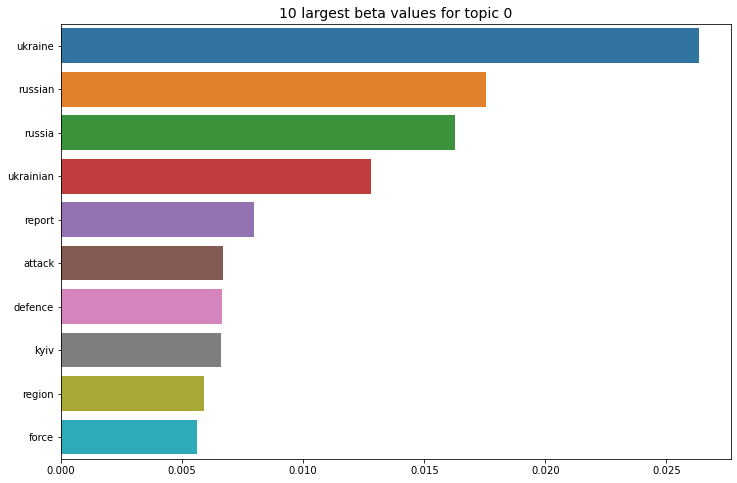

In [49]:
#Visualizing topic 10

#beta_df.iloc[41].nlargest(10) locates the 10 largest values in row 41. 
# .values returns the beta values
# .index returns the words

plt.figure(figsize = (12,8))

ax = sns.barplot(x = beta_df.iloc[0].nlargest(10).values, 
                 y = beta_df.iloc[0].nlargest(10).index, 
                 orient = 'h')

plt.title('10 largest beta values for topic 0', fontsize = 14)
plt.show()

### 4.2. Investigating results: gamma parameters

In [16]:
#Insert the corpus of documents in bag of word format and get an array of (document, topic, probability). 

document_topics = np.array(lda_model.get_document_topics(corpus, minimum_probability=0.0)) 

In [17]:
#Creating a list of names for all 20 topics
topics = ['topic_{}'.format(t) for t in range(0,20)]

#Creating a dataframe of gamma probabilities 
gamma_probs = pd.DataFrame(document_topics[:,:,1], columns = topics)

In [18]:
#Merging with the original dataframe 
gamma_df = pd.concat((df, gamma_probs), axis = 1)

#Viewing the concatenated dataframe
gamma_df.head()

,Unnamed: 0,URL,Datetime,Title,Text,Affiliation,processed_text,processed_filtered_text,lemma_text,unigrams,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,9908,world/2021/aug/03/belarus-exile-group-leader-v...,2021-08-03,Belarus exile group leader Vitaly Shishov foun...,The head of a Kyiv-based non-profit organisati...,Guardian,head Kyiv-based non-profit organisation helps ...,head kyiv based non profit organisation helps ...,head kyiv base non profit organisation help be...,"[head, kyiv, base, non, profit, organisation, ...",...,0.000120,0.000120,0.000120,0.183277,0.436168,0.000120,0.000120,0.000120,0.000120,0.000120
1,9909,world/2021/aug/03/uk-on-your-side-boris-johnso...,2021-08-03,"UK is on your side, Boris Johnson tells Belaru...",The UK is on the side of Belarusian opposition...,Guardian,UK side Belarusian opposition leaders trying b...,uk side belarusian opposition leaders trying b...,uk side belarusian opposition leader try bring...,"[uk, side, belarusian, opposition, leader, try...",...,0.000150,0.020470,0.029467,0.067516,0.340315,0.023287,0.000150,0.000150,0.000150,0.000150
2,9907,world/2021/aug/03/anger-in-turkey-grows-over-g...,2021-08-03,Anger in Turkey grows over government’s handli...,People across Turkey are looking for answers a...,Guardian,People across Turkey looking answers summer wi...,people across turkey looking answers summer wi...,people across turkey look answer summer wildfi...,"[people, across, turkey, look, answer, summer,...",...,0.000100,0.000100,0.153530,0.326539,0.000100,0.000100,0.000100,0.057445,0.000100,0.000100
3,9911,world/2021/aug/07/greek-firefighter-killed-ath...,2021-08-07,Greek firefighter killed and 20 injured as fir...,A volunteer firefighter has been killed in a b...,Guardian,volunteer firefighter killed blaze threatening...,volunteer firefighter killed blaze threatening...,volunteer firefighter kill blaze threaten gree...,"[volunteer, firefighter, kill, blaze, threaten...",...,0.000168,0.000168,0.181727,0.303845,0.000168,0.000168,0.000168,0.087184,0.000168,0.000168
4,9910,world/2021/aug/07/belarus-danger-belarusian-di...,2021-08-07,Belarus exiles fear the long arm of the vengef...,It is a fraught and dangerous time to be a Bel...,Guardian,fraught dangerous time Belarusian activist dis...,fraught dangerous time belarusian activist dis...,fraught dangerous time belarusian activist dis...,"[fraught, dangerous, time, belarusian, activis...",...,0.000057,0.000057,0.077471,0.227289,0.319621,0.000057,0.000057,0.000057,0.000057,0.000057


### 4.3. Theta

In [67]:
df_theta = df.copy()

In [68]:
# Get theta for all documents and create a DataFrame
theta_probs = pd.DataFrame([dict(lda_model.get_document_topics(document_bow)) for document_bow in corpus])

# Rename columns to 'topic_0', 'topic_1', ..., 'topic_19'
theta_probs.columns = ['topic_{}'.format(t) for t in range(lda_model.num_topics)]

# Concatenate the original DataFrame with the new theta DataFrame
df_theta = pd.concat([df_theta, theta_probs], axis=1)

df_theta

,URL,Datetime,Title,Text,Affiliation,processed_text,processed_filtered_text,lemma_text,unigrams,bigrams,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,world/2021/aug/03/belarus-exile-group-leader-v...,2021-08-03,Belarus exile group leader Vitaly Shishov foun...,The head of a Kyiv-based non-profit organisati...,Guardian,head Kyiv-based non-profit organisation helps ...,head kyiv based non profit organisation helps ...,head kyiv base non profit organisation help be...,"[head, kyiv, base, non, profit, organisation, ...","[head_kyiv, kyiv_base, base_non, non_profit, p...",...,0.000120,0.000120,0.000120,0.183277,0.436171,0.000120,0.000120,0.000120,0.000120,0.000120
1,world/2021/aug/03/uk-on-your-side-boris-johnso...,2021-08-03,"UK is on your side, Boris Johnson tells Belaru...",The UK is on the side of Belarusian opposition...,Guardian,UK side Belarusian opposition leaders trying b...,uk side belarusian opposition leaders trying b...,uk side belarusian opposition leader try bring...,"[uk, side, belarusian, opposition, leader, try...","[uk_side, side_belarusian, belarusian_oppositi...",...,0.000150,0.020413,0.029574,0.067436,0.340333,0.023300,0.000150,0.000150,0.000150,0.000150
2,world/2021/aug/03/anger-in-turkey-grows-over-g...,2021-08-03,Anger in Turkey grows over government’s handli...,People across Turkey are looking for answers a...,Guardian,People across Turkey looking answers summer wi...,people across turkey looking answers summer wi...,people across turkey look answer summer wildfi...,"[people, across, turkey, look, answer, summer,...","[people_across, across_turkey, turkey_look, lo...",...,0.000100,0.000100,0.153531,0.326538,0.000100,0.000100,0.000100,0.057436,0.000100,0.000100
3,world/2021/aug/07/greek-firefighter-killed-ath...,2021-08-07,Greek firefighter killed and 20 injured as fir...,A volunteer firefighter has been killed in a b...,Guardian,volunteer firefighter killed blaze threatening...,volunteer firefighter killed blaze threatening...,volunteer firefighter kill blaze threaten gree...,"[volunteer, firefighter, kill, blaze, threaten...","[volunteer_firefighter, firefighter_kill, kill...",...,0.000168,0.000168,0.181729,0.303852,0.000168,0.000168,0.000168,0.087188,0.000168,0.000168
4,world/2021/aug/07/belarus-danger-belarusian-di...,2021-08-07,Belarus exiles fear the long arm of the vengef...,It is a fraught and dangerous time to be a Bel...,Guardian,fraught dangerous time Belarusian activist dis...,fraught dangerous time belarusian activist dis...,fraught dangerous time belarusian activist dis...,"[fraught, dangerous, time, belarusian, activis...","[fraught_dangerous, dangerous_time, time_belar...",...,0.000057,0.000057,0.077471,0.227290,0.319622,0.000057,0.000057,0.000057,0.000057,0.000057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14218,https://www.breitbart.com/europe/2023/12/06/uk...,2023-12-06,"Ukraine Assassinates Zelensky Critic 'Traitor,...","Ilya Kiva, who was a Member of Parliament in U...",BreitBart,"Ilya Kiva, Member Parliament Ukraine war start...",ilya kiva member parliament ukraine war starte...,ilya kiva member parliament ukraine war start ...,"[ilya, kiva, member, parliament, ukraine, war,...","[ilya_kiva, kiva_member, member_parliament, pa...",...,0.000135,0.000135,0.000135,0.000135,0.242843,0.000135,0.000135,0.000135,0.000135,0.000135
14219,https://www.breitbart.com/entertainment/2023/1...,2023-12-07,Actors Duped into Recording Videos for ‘Vladim...,A host of actors were tricked by internet prop...,BreitBart,host actors tricked internet propagandists mak...,host actors tricked internet propagandists mak...,host actor trick internet propagandist make vi...,"[host, actor, trick, internet, propagandist, m...","[host_actor, actor_trick, trick_internet, inte...",...,0.000253,0.000253,0.000253,0.000253,0.538363,0.000253,0.000253,0.000253,0.000253,0.000253
14220,https://www.breitbart.com/middle-east/2023/12/...,

In [80]:
# # Get theta for all documents and append it to the DataFrame
# theta_list = []

# for document_bow in corpus:
#     theta = dict(lda_model.get_document_topics(document_bow))
#     theta_list.append(theta)

# df_theta['theta'] = theta_list

# # Display the DataFrame with the new 'theta' column
# df_theta.head()

### 5. Visualizing the development of our topic

In [20]:
import matplotlib.dates as mdates

In [19]:
# Sort the DataFrame by the 'Datetime' column
gamma_df = gamma_df.sort_values('Datetime')
gamma_df

,Unnamed: 0,URL,Datetime,Title,Text,Affiliation,processed_text,processed_filtered_text,lemma_text,unigrams,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,9908,world/2021/aug/03/belarus-exile-group-leader-v...,2021-08-03,Belarus exile group leader Vitaly Shishov foun...,The head of a Kyiv-based non-profit organisati...,Guardian,head Kyiv-based non-profit organisation helps ...,head kyiv based non profit organisation helps ...,head kyiv base non profit organisation help be...,"[head, kyiv, base, non, profit, organisation, ...",...,0.000120,0.000120,0.000120,0.183277,0.436168,0.000120,0.000120,0.000120,0.000120,0.000120
2,9907,world/2021/aug/03/anger-in-turkey-grows-over-g...,2021-08-03,Anger in Turkey grows over government’s handli...,People across Turkey are looking for answers a...,Guardian,People across Turkey looking answers summer wi...,people across turkey looking answers summer wi...,people across turkey look answer summer wildfi...,"[people, across, turkey, look, answer, summer,...",...,0.000100,0.000100,0.153530,0.326539,0.000100,0.000100,0.000100,0.057445,0.000100,0.000100
9888,52,https://www.breitbart.com/europe/2021/08/03/ma...,2021-08-03,Man Who Helped Persecuted Belarussians Flee Fo...,"KYIV, Ukraine (AP) – A Belarusian activist who...",BreitBart,"KYIV, Ukraine (AP) – Belarusian activist ran g...",kyiv ukraine ap – belarusian activist ran grou...,kyiv ukraine ap – belarusian activist run grou...,"[kyiv, ukraine, ap, belarusian, activist, run,...",...,0.028506,0.000176,0.000176,0.232732,0.282032,0.000176,0.000176,0.000176,0.000176,0.000176
1,9909,world/2021/aug/03/uk-on-your-side-boris-johnso...,2021-08-03,"UK is on your side, Boris Johnson tells Belaru...",The UK is on the side of Belarusian opposition...,Guardian,UK side Belarusian opposition leaders trying b...,uk side belarusian opposition leaders trying b...,uk side belarusian opposition leader try bring...,"[uk, side, belarusian, opposition, leader, try...",...,0.000150,0.020470,0.029467,0.067516,0.340315,0.023287,0.000150,0.000150,0.000150,0.000150
9889,53,https://www.breitbart.com/national-security/20...,2021-08-04,Lesbian Family Featured in Grocery Store Ad Fl...,A Russian lesbian couple and their daughters h...,BreitBart,Russian lesbian couple daughters “fled country...,russian lesbian couple daughters fled country ...,russian lesbian couple daughter flee country s...,"[russian, lesbian, couple, daughter, flee, cou...",...,0.000132,0.000132,0.000132,0.078950,0.274251,0.000132,0.017877,0.128335,0.040351,0.000132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14218,8644,https://www.breitbart.com/europe/2023/12/06/uk...,2023-12-06,"Ukraine Assassinates Zelensky Critic 'Traitor,...","Ilya Kiva, who was a Member of Parliament in U...",BreitBart,"Ilya Kiva, Member Parliament Ukraine war start...",ilya kiva member parliament ukraine war starte...,ilya kiva member parliament ukraine war start ...,"[ilya, kiva, member, parliament, ukraine, war,...",...,0.000135,0.000135,0.000135,0.000135,0.242851,0.000135,0.000135,0.000135,0.000135,0.000135
14221,8650,https://www.breitbart.com/europe/2023/12/07/ru...,2023-12-07,Russia Hacking Western Politicians to 'Undermi...,Russian hackers are “selectively” leaking mate...,BreitBart,Russian hackers “selectively” leaking material...,russian hackers selectively leaking material o...,russian hacker selectively leak material obtai...,"[russian, hacker, selectively, leak, material,...",...,0.043861,0.038318,0.000189,0.000189,0.419181,0.000189,0.000189,0.000189,0.000189,0.000189
14219,8646,https://www.breitbart.com/entertainment/2023/1...,2023-12-07,Actors Duped into Recording Videos for ‘Vladim...,A host of actors were tricked by internet prop...,BreitBart,host actors tricked internet propagandists mak...,host actors tricked internet propagandists mak...,host actor trick internet propagandist make vi...,"[host, actor, trick, internet, propagandi

In [30]:
import pandas as pd

# Assuming df_m is your DataFrame with a 'Datetime' column and a 'Values' column
# Copy the DataFrame to avoid modifying the original
df_m = gamma_df.copy()

# Convert 'Datetime' to datetime format and set it as the index
df_m['Datetime'] = pd.to_datetime(df_m['Datetime'])
df_m.set_index('Datetime', inplace=True)

# Resample based on monthly frequency and calculate the sum
df_t0 = df_m.resample(rule='M')['topic_0'].sum().to_frame(name='Sum_Values')

# Display the result
df_t0

,Sum_Values
Datetime,
2021-08-31,0.604017
2021-09-30,0.037677
2021-10-31,0.930107
2021-11-30,0.601345
2021-12-31,1.364562
2022-01-31,5.270983
2022-02-28,30.793398
2022-03-31,68.019331
2022-04-30,41.418781


In [36]:
# # monthly binning

# # Assuming df_m is your DataFrame with a 'Datetime' column, a 'Values' column, and a 'Category' column
# # Copy the DataFrame to avoid modifying the original
# df_m = gamma_df.copy()

# # Convert 'Datetime' to datetime format and set it as the index
# df_m['Datetime'] = pd.to_datetime(df_m['Datetime'])
# df_m.set_index('Datetime', inplace=True)

# # Resample based on monthly frequency and calculate the sum, grouped by 'Category'
# df_t0_grouped = df_m.groupby('Affiliation').resample(rule='M')['topic_0'].mean().to_frame(name='Mean_Values')

# # Display the result
# print(df_t0_grouped)


                        Sum_Values
Affiliation Datetime              
BreitBart   2021-08-31    0.008126
            2021-09-30    0.002058
            2021-10-31    0.009368
            2021-11-30    0.001475
            2021-12-31    0.000192
            2022-01-31    0.005317
            2022-02-28    0.023769
            2022-03-31    0.009475
            2022-04-30    0.013497
            2022-05-31    0.005314
            2022-06-30    0.012163
            2022-07-31    0.043943
            2022-08-31    0.029901
            2022-09-30    0.013944
            2022-10-31    0.054053
            2022-11-30    0.047874
            2022-12-31    0.038269
            2023-01-31    0.047805
            2023-02-28    0.014936
            2023-03-31    0.020473
            2023-04-30    0.017697
            2023-05-31    0.038254
            2023-06-30    0.033667
            2023-07-31    0.076634
            2023-08-31    0.076123
            2023-09-30    0.049756
            2023-10-

In [42]:
df_m = gamma_df.copy()

# Convert 'Datetime' to datetime format and set it as the index
df_m['Datetime'] = pd.to_datetime(df_m['Datetime'])
df_m.set_index('Datetime', inplace=True)

# Resample based on two-week frequency and calculate the mean, grouped by 'Affiliation'
df_t0_grouped = df_m.groupby('Affiliation').resample(rule='2W')['topic_0'].mean().to_frame(name='Mean_Values')

# Display the result
print(df_t0_grouped)

                        Mean_Values
Affiliation Datetime               
BreitBart   2021-08-08     0.000159
            2021-08-22     0.004949
            2021-09-05     0.010064
            2021-09-19     0.000145
            2021-10-03     0.004201
...                             ...
Guardian    2023-10-15     0.157897
            2023-10-29     0.118330
            2023-11-12     0.137546
            2023-11-26     0.148450
            2023-12-10     0.161309

[124 rows x 1 columns]


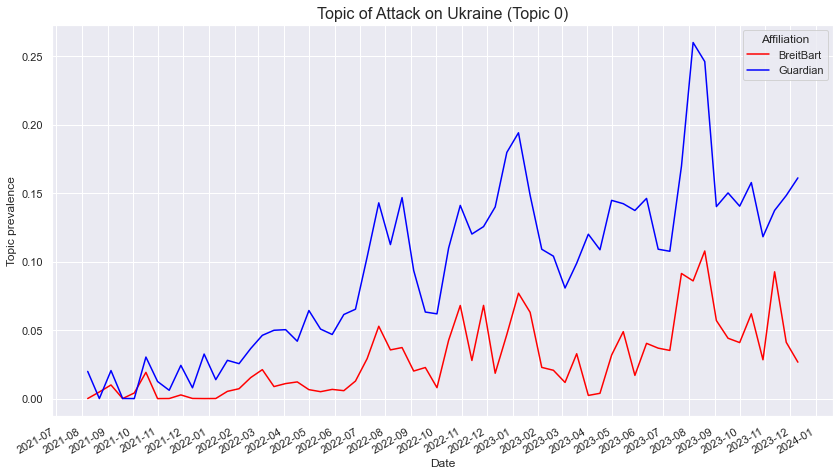

In [43]:
#Setting a theme
sns.set_theme(style="darkgrid")

#Plotting a figure and setting figure size
plt.figure(figsize = (14,8))

#Choosing colors
palette = ['red','blue'] 

#Plotting the covid topic for the full dataset
sns.lineplot(x = 'Datetime', y = 'Mean_Values', hue = 'Affiliation', data = df_t0_grouped, palette = palette)

plt.title('Topic of Attack on Ukraine (Topic 0)', fontsize = 16)
plt.ylabel('Topic prevalence')
plt.xlabel('Date')

# # Setting x-axis ticks to show every month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()  # Auto-format the x-axis date labels for better readability

plt.show()

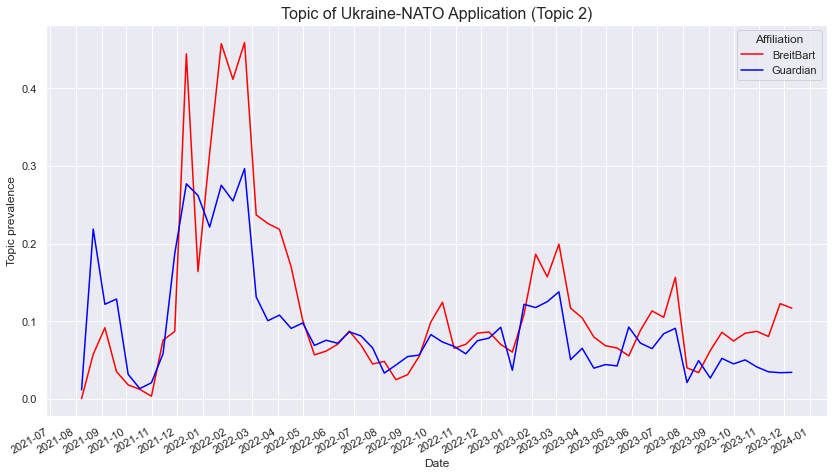

In [55]:
# Sort the DataFrame by the 'Datetime' column
df_t2_grouped = df_m.groupby('Affiliation').resample(rule='2W')['topic_2'].mean().to_frame(name='Mean_Values')

#Setting a theme
sns.set_theme(style="darkgrid")

#Plotting a figure and setting figure size
plt.figure(figsize = (14,8))

#Choosing colors
palette = ['red','blue'] 

#Plotting the topic for the full dataset
sns.lineplot(x = 'Datetime', y = 'Mean_Values', hue = 'Affiliation', data = df_t2_grouped, palette = palette)

plt.title('Topic of Ukraine-NATO Application (Topic 2)', fontsize = 16)
plt.ylabel('Topic prevalence')
plt.xlabel('Date')

# # Setting x-axis ticks to show every month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()  # Auto-format the x-axis date labels for better readability

plt.show()

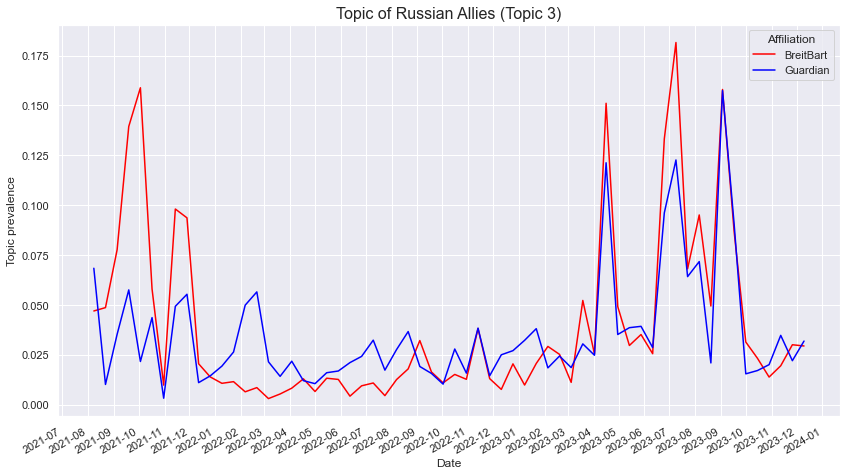

In [53]:
# Sort the DataFrame by the 'Datetime' column
df_t3_grouped = df_m.groupby('Affiliation').resample(rule='2W')['topic_3'].mean().to_frame(name='Mean_Values')

#Setting a theme
sns.set_theme(style="darkgrid")

#Plotting a figure and setting figure size
plt.figure(figsize = (14,8))

#Choosing colors
palette = ['red','blue'] 

#Plotting the topic for the full dataset
sns.lineplot(x = 'Datetime', y = 'Mean_Values', hue = 'Affiliation', data = df_t3_grouped, palette = palette)

plt.title('Topic of Russian Allies (Topic 3)', fontsize = 16)
plt.ylabel('Topic prevalence')
plt.xlabel('Date')

# # Setting x-axis ticks to show every month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()  # Auto-format the x-axis date labels for better readability

plt.show()

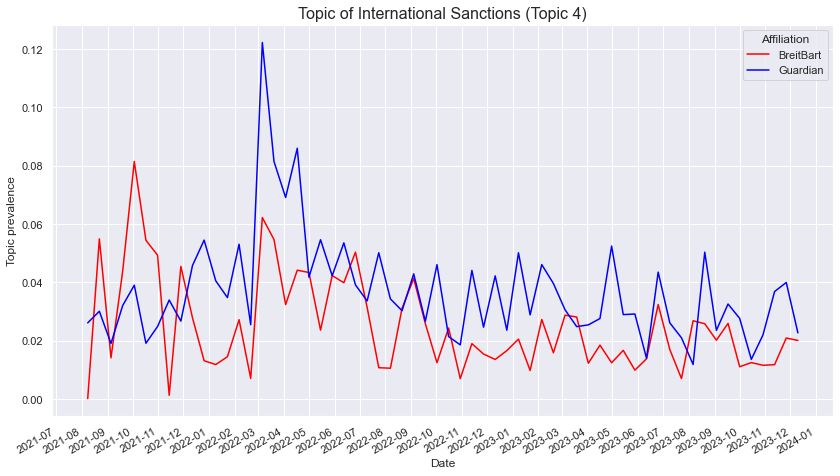

In [56]:
df_t4_grouped = df_m.groupby('Affiliation').resample(rule='2W')['topic_4'].mean().to_frame(name='Mean_Values')

#Setting a theme
sns.set_theme(style="darkgrid")

#Plotting a figure and setting figure size
plt.figure(figsize = (14,8))

#Choosing colors
palette = ['red','blue'] 

#Plotting the topic for the full dataset
sns.lineplot(x = 'Datetime', y = 'Mean_Values', hue = 'Affiliation', data = df_t4_grouped, palette = palette)

plt.title('Topic of International Sanctions (Topic 4)', fontsize = 16)
plt.ylabel('Topic prevalence')
plt.xlabel('Date')

# # Setting x-axis ticks to show every month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()  # Auto-format the x-axis date labels for better readability

plt.show()

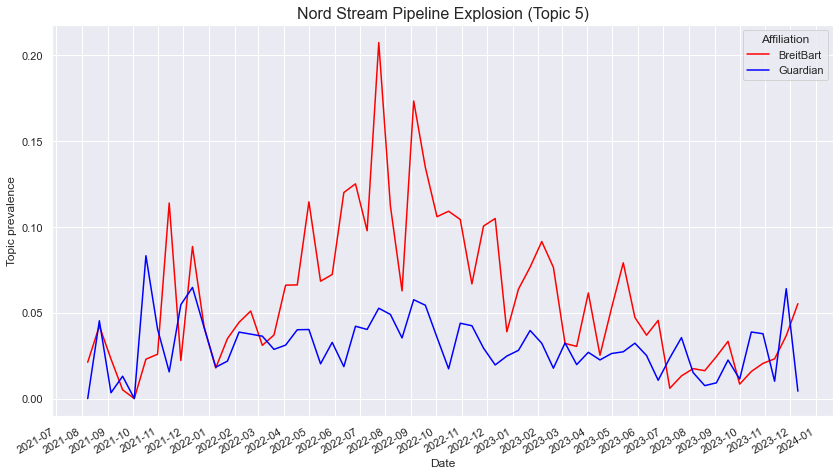

In [60]:
df_t5_grouped = df_m.groupby('Affiliation').resample(rule='2W')['topic_5'].mean().to_frame(name='Mean_Values')

#Setting a theme
sns.set_theme(style="darkgrid")

#Plotting a figure and setting figure size
plt.figure(figsize = (14,8))

#Choosing colors
palette = ['red','blue'] 

#Plotting the topic for the full dataset
sns.lineplot(x = 'Datetime', y = 'Mean_Values', hue = 'Affiliation', data = df_t5_grouped, palette = palette)

plt.title('Nord Stream Pipeline Explosion (Topic 5)', fontsize = 16)
plt.ylabel('Topic prevalence')
plt.xlabel('Date')

# # Setting x-axis ticks to show every month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()  # Auto-format the x-axis date labels for better readability

plt.show()

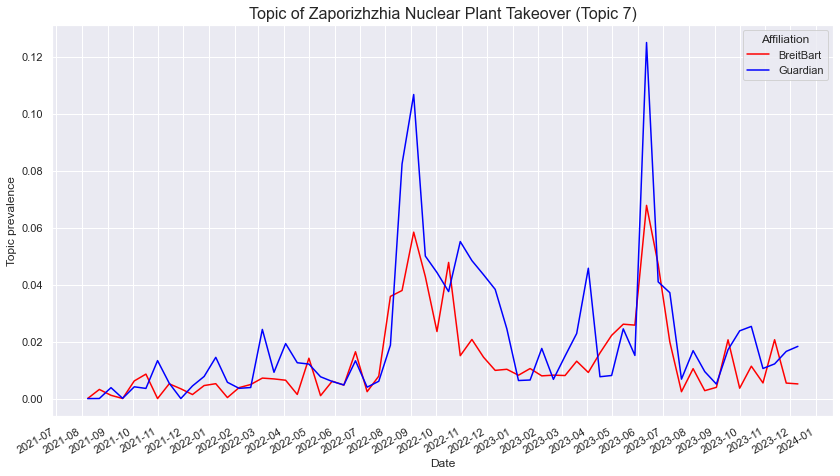

In [61]:
df_t7_grouped = df_m.groupby('Affiliation').resample(rule='2W')['topic_7'].mean().to_frame(name='Mean_Values')

#Setting a theme
sns.set_theme(style="darkgrid")

#Plotting a figure and setting figure size
plt.figure(figsize = (14,8))

#Choosing colors
palette = ['red','blue'] 

#Plotting the topic for the full dataset
sns.lineplot(x = 'Datetime', y = 'Mean_Values', hue = 'Affiliation', data = df_t7_grouped, palette = palette)

plt.title('Topic of Zaporizhzhia Nuclear Plant Takeover (Topic 7)', fontsize = 16)
plt.ylabel('Topic prevalence')
plt.xlabel('Date')

# # Setting x-axis ticks to show every month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()  # Auto-format the x-axis date labels for better readability

plt.show()

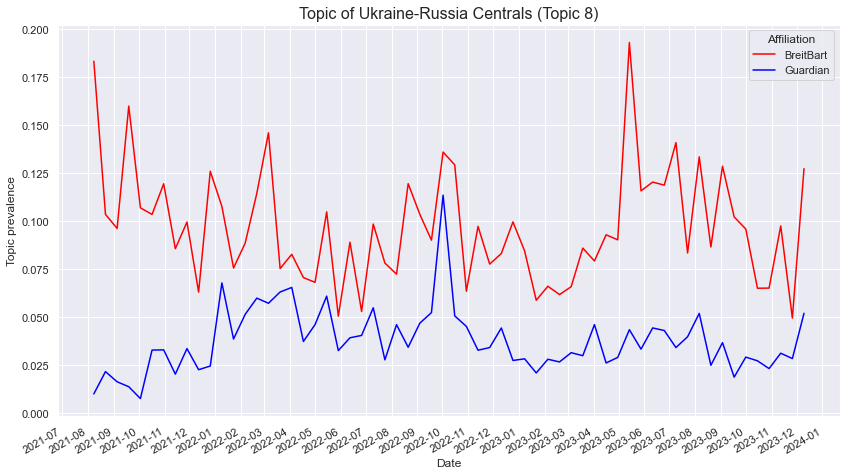

In [62]:
df_t8_grouped = df_m.groupby('Affiliation').resample(rule='2W')['topic_8'].mean().to_frame(name='Mean_Values')

#Setting a theme
sns.set_theme(style="darkgrid")

#Plotting a figure and setting figure size
plt.figure(figsize = (14,8))

#Choosing colors
palette = ['red','blue'] 

#Plotting the topic for the full dataset
sns.lineplot(x = 'Datetime', y = 'Mean_Values', hue = 'Affiliation', data = df_t8_grouped, palette = palette)

plt.title('Topic of Ukraine-Russia Centrals (Topic 8)', fontsize = 16)
plt.ylabel('Topic prevalence')
plt.xlabel('Date')

# # Setting x-axis ticks to show every month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()  # Auto-format the x-axis date labels for better readability

plt.show()

NameError: name 'b' is not defined

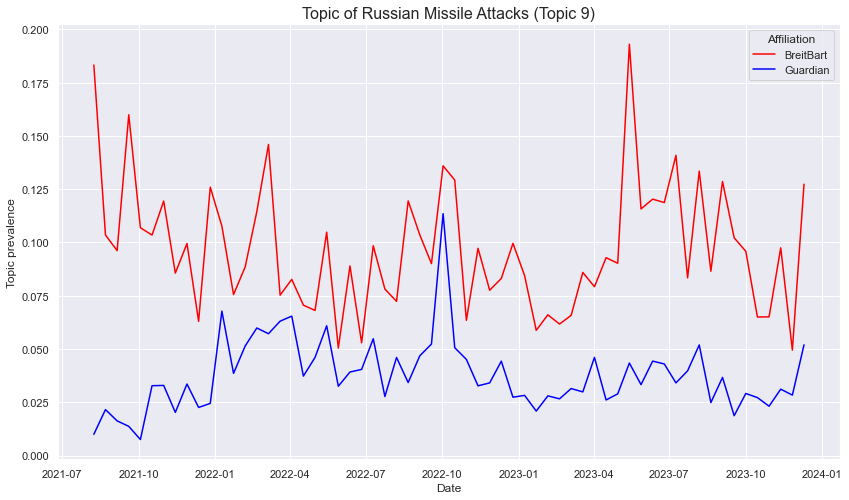

In [65]:
df_t9_grouped = df_m.groupby('Affiliation').resample(rule='2W')['topic_8'].mean().to_frame(name='Mean_Values')

#Setting a theme
sns.set_theme(style="darkgrid")

#Plotting a figure and setting figure size
plt.figure(figsize = (14,8))

#Choosing colors
palette = ['red','blue'] 

#Plotting the covid topic for the full dataset
sns.lineplot(x = 'Datetime', y = 'Mean_Values', hue = 'Affiliation', data = df_t9_grouped, palette = palette)

plt.title('Topic of Russian Missile Attacks (Topic 9)', fontsize = 16)
plt.ylabel('Topic prevalence')
plt.xlabel('Date')
b
# Setting x-axis ticks to the first day of every month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
plt.gcf().autofmt_xdate()  # Auto-format the x-axis date labels for better readability

plt.show()

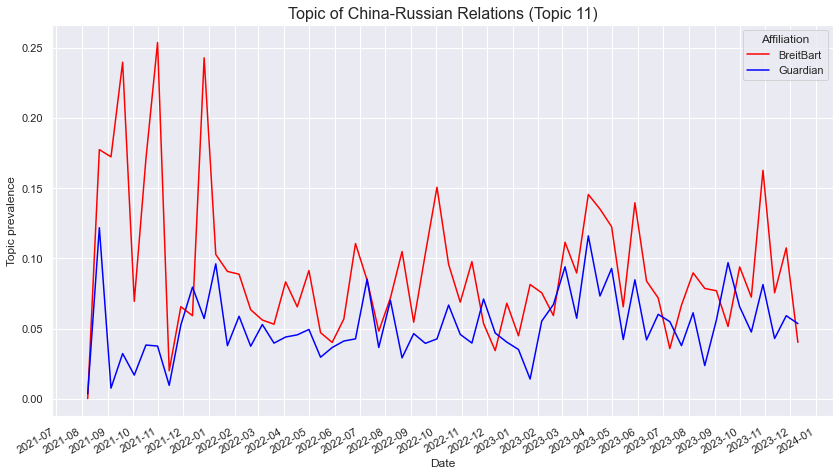

In [69]:
df_t11_grouped = df_m.groupby('Affiliation').resample(rule='2W')['topic_11'].mean().to_frame(name='Mean_Values')

#Setting a theme
sns.set_theme(style="darkgrid")

#Plotting a figure and setting figure size
plt.figure(figsize = (14,8))

#Choosing colors
palette = ['red','blue'] 

#Plotting the covid topic for the full dataset
sns.lineplot(x = 'Datetime', y = 'Mean_Values', hue = 'Affiliation', data = df_t11_grouped, palette = palette)

plt.title('Topic of China-Russian Relations (Topic 11)', fontsize = 16)
plt.ylabel('Topic prevalence')
plt.xlabel('Date')

# Setting x-axis ticks to the first day of every month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
plt.gcf().autofmt_xdate()  # Auto-format the x-axis date labels for better readability

plt.show()

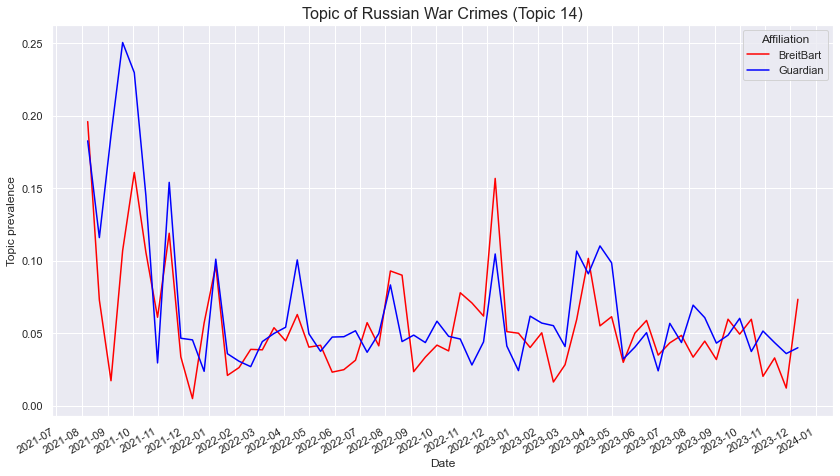

In [58]:
df_t14_grouped = df_m.groupby('Affiliation').resample(rule='2W')['topic_14'].mean().to_frame(name='Mean_Values')

#Setting a theme
sns.set_theme(style="darkgrid")

#Plotting a figure and setting figure size
plt.figure(figsize = (14,8))

#Choosing colors
palette = ['red','blue'] 

#Plotting the covid topic for the full dataset
sns.lineplot(x = 'Datetime', y = 'Mean_Values', hue = 'Affiliation', data = df_t14_grouped, palette = palette)

plt.title('Topic of Russian War Crimes (Topic 14)', fontsize = 16)
plt.ylabel('Topic prevalence')
plt.xlabel('Date')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
plt.gcf().autofmt_xdate()  # Auto-format the x-axis date labels for better readability

plt.show()

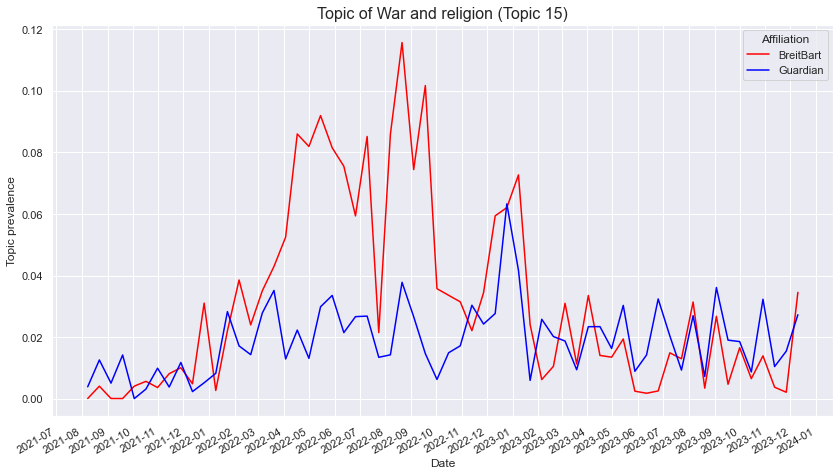

In [68]:
df_t15_grouped = df_m.groupby('Affiliation').resample(rule='2W')['topic_15'].mean().to_frame(name='Mean_Values')

#Setting a theme
sns.set_theme(style="darkgrid")

#Plotting a figure and setting figure size
plt.figure(figsize = (14,8))

#Choosing colors
palette = ['red','blue'] 

#Plotting the covid topic for the full dataset
sns.lineplot(x = 'Datetime', y = 'Mean_Values', hue = 'Affiliation', data = df_t15_grouped, palette = palette)

plt.title('Topic of War and religion (Topic 15)', fontsize = 16)
plt.ylabel('Topic prevalence')
plt.xlabel('Date')

# Setting x-axis ticks to the first day of every month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
plt.gcf().autofmt_xdate()  # Auto-format the x-axis date labels for better readability

plt.show()

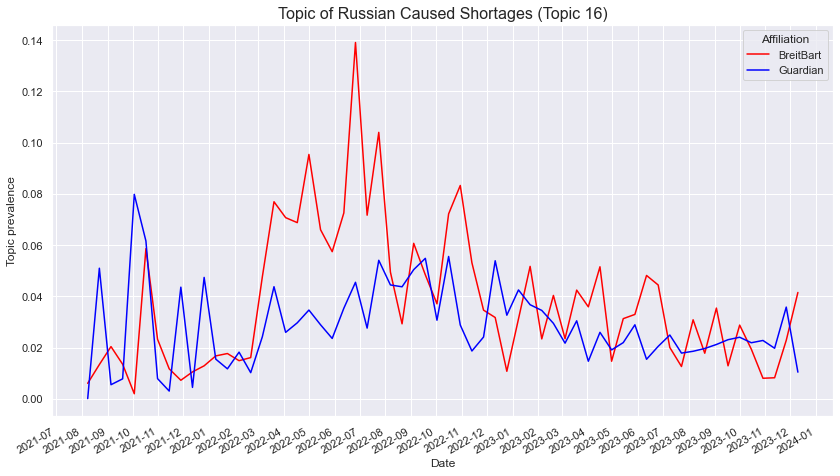

In [70]:
df_t16_grouped = df_m.groupby('Affiliation').resample(rule='2W')['topic_16'].mean().to_frame(name='Mean_Values')

#Setting a theme
sns.set_theme(style="darkgrid")

#Plotting a figure and setting figure size
plt.figure(figsize = (14,8))

#Choosing colors
palette = ['red','blue'] 

#Plotting the covid topic for the full dataset
sns.lineplot(x = 'Datetime', y = 'Mean_Values', hue = 'Affiliation', data = df_t16_grouped, palette = palette)

plt.title('Topic of Russian Caused Shortages (Topic 16)', fontsize = 16)
plt.ylabel('Topic prevalence')
plt.xlabel('Date')

# Setting x-axis ticks to the first day of every month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
plt.gcf().autofmt_xdate()  # Auto-format the x-axis date labels for better readability

plt.show()

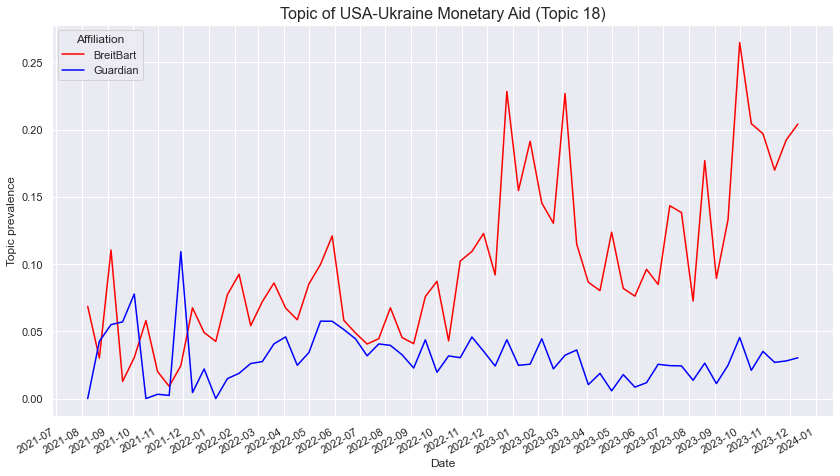

In [51]:
# Sort the DataFrame by the 'Datetime' column
df_t18_grouped = df_m.groupby('Affiliation').resample(rule='2W')['topic_18'].mean().to_frame(name='Mean_Values')

#Setting a theme
sns.set_theme(style="darkgrid")

#Plotting a figure and setting figure size
plt.figure(figsize = (14,8))

#Choosing colors
palette = ['red','blue'] 

#Plotting the covid topic for the full dataset
sns.lineplot(x = 'Datetime', y = 'Mean_Values', hue = 'Affiliation', data = df_t18_grouped, palette = palette)

plt.title('Topic of USA-Ukraine Monetary Aid (Topic 18)', fontsize = 16)
plt.ylabel('Topic prevalence')
plt.xlabel('Date')

# Setting x-axis ticks to the first day of every month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
plt.gcf().autofmt_xdate()  # Auto-format the x-axis date labels for better readability

plt.show()

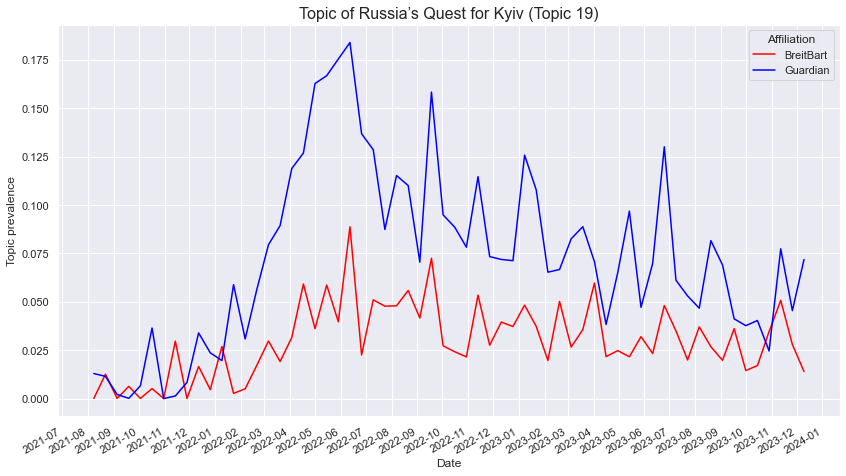

In [50]:
df_t19_grouped = df_m.groupby('Affiliation').resample(rule='2W')['topic_19'].mean().to_frame(name='Mean_Values')

#Setting a theme
sns.set_theme(style="darkgrid")

#Plotting a figure and setting figure size
plt.figure(figsize = (14,8))

#Choosing colors
palette = ['red','blue'] 

#Plotting the covid topic for the full dataset
sns.lineplot(x = 'Datetime', y = 'Mean_Values', hue = 'Affiliation', data = df_t19_grouped, palette = palette)

plt.title('Topic of Russia’s Quest for Kyiv (Topic 19)', fontsize = 16)
plt.ylabel('Topic prevalence')
plt.xlabel('Date')

# Setting x-axis ticks to the first day of every month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
plt.gcf().autofmt_xdate()  # Auto-format the x-axis date labels for better readability

plt.show()

### 6. Comparative metrics

In [91]:
# Create an empty DataFrame to store the results
mean_results = pd.DataFrame(columns=['Affiliation'] + topics)

# Calculate the mean for each affiliation and each topic
for topic in topics:
    mean_by_affiliation = gamma_df.groupby('Affiliation')[topic].mean()
    mean_results = pd.concat([mean_results, mean_by_affiliation], axis=1)

# Print the mean results
mean_results

,Affiliation,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
BreitBart,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.038850,0.07871,0.057874,0.03347,0.048451,0.038263,0.046659,0.016599,0.101529,0.032031
Guardian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.056341,0.05275,0.059061,0.06208,0.054019,0.022009,0.030183,0.020284,0.031741,0.092032


In [93]:
mean_results_dropped = mean_results.iloc[:, 21:]
mean_results_dropped

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
BreitBart,0.027570,0.039350,0.148180,0.028012,0.030888,0.058178,0.007024,0.013032,0.096711,0.058618,0.038850,0.07871,0.057874,0.03347,0.048451,0.038263,0.046659,0.016599,0.101529,0.032031
Guardian,0.097389,0.090605,0.087305,0.031569,0.045916,0.031888,0.024863,0.023456,0.043461,0.043049,0.056341,0.05275,0.059061,0.06208,0.054019,0.022009,0.030183,0.020284,0.031741,0.092032


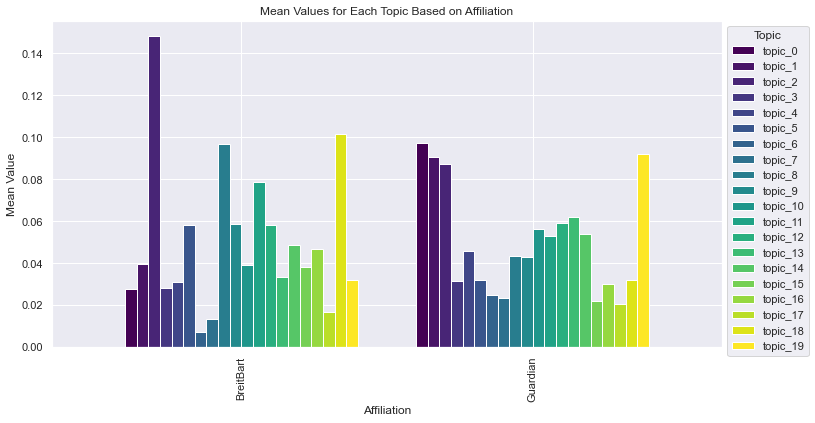

In [94]:
import matplotlib.pyplot as plt

# Assuming mean_results_dropped is your DataFrame with mean values after dropping the first 20 columns

# Plot a bar chart
ax = mean_results_dropped.plot.bar(figsize=(12, 6), width=0.8, colormap='viridis')

# Set plot labels and title
ax.set_ylabel('Mean Value')
ax.set_xlabel('Affiliation')
ax.set_title('Mean Valuebs for Each Topic Based on Affiliation')

# Display the legend
ax.legend(title='Topic', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

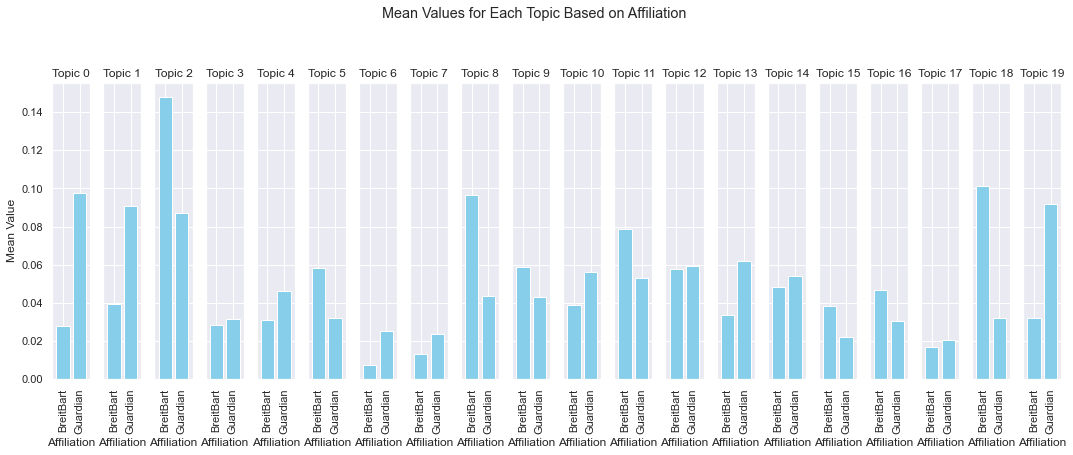

In [102]:
import matplotlib.pyplot as plt

# Assuming mean_results_dropped is your DataFrame with mean values after dropping the first 20 columns

# List of topics
topics = mean_results_dropped.columns

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=len(topics), figsize=(15, 6), sharey=True)

# Iterate through topics and create a bar chart for each
for i, topic in enumerate(topics):
    ax = mean_results_dropped[topic].plot.bar(ax=axes[i], color='skyblue', width=0.8)
    ax.set_title(f'Topic {i}')
    ax.set_xlabel('Affiliation')
    ax.set_ylabel('Mean Value')

# Set the overall title
plt.suptitle('Mean Values for Each Topic Based on Affiliation', y=1.05)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [104]:
# import matplotlib.pyplot as plt

# # Assuming mean_results_dropped is your DataFrame with mean values after dropping the first 20 columns

# # List of topics
# topics = mean_results_dropped.columns

# # Set up subplots
# fig, axes = plt.subplots(nrows=1, ncols=len(topics), figsize=(15, 6), sharey=True)

# # Define colors for each affiliation
# colors = {'BB': 'skyblue', 'TG': 'lightcoral'}  # Add more affiliations and colors as needed

# # Iterate through topics and create a bar chart for each
# for i, topic in enumerate(topics):
#     ax = mean_results_dropped[topic].T.plot.bar(ax=axes[i], color=[colors[aff] for aff in mean_results_dropped.index], width=0.8)
#     ax.set_title(f'Topic {i}')
#     ax.set_xlabel('Affiliation')
#     ax.set_ylabel('Mean Value')

# # Set the overall title
# plt.suptitle('Mean Values for Each Topic Based on Affiliation', y=1.05)

# # Adjust layout to prevent overlap
# plt.tight_layout()

# # Show the plot
# plt.show()


### Word embeddings

In [105]:
from gensim.models import Word2Vec

# Train Word2Vec model
model = Word2Vec(sentences=df['tokens'].tolist(), vector_size=100, window=5, min_count=1, workers=4)

# Access word vectors
vector_word_embeddings = model.wv['word']

# Find similar words
similar_words = model.wv.most_similar('word', topn=5)

print("Word Vector:", vector_word_embeddings)
print("Similar Words:", similar_words)

Word Vector: [ 0.15795392  0.45382196 -0.40298775  0.8110661   4.372914    1.8247854
  0.11698353 -3.4604387   1.871125    0.70229715 -3.48499     0.15111496
 -1.6993105  -0.7210547  -2.9808476  -0.2595658  -4.2193327   0.57308114
 -0.04066428  3.729436   -2.4164948   3.098186   -1.9961218   2.7152503
  0.93611556  0.13049172  0.8349775   3.0652864  -0.05896695 -2.264682
 -2.3820019   0.1777418   0.594499    0.7235437  -0.31787995 -2.671873
  1.2817165  -2.354147   -0.10410745 -0.51714575 -0.12483483  3.072711
 -1.9626176  -1.2187955  -0.14822789  0.7566455   3.1059196  -1.0941516
  2.5979996   0.80306697 -0.8618498  -1.6507267  -0.22567031 -2.7763002
 -2.2148569  -0.3188909  -0.35835168 -0.7340992  -2.8322504  -0.7351308
  4.9268737   0.21971136  0.38458106  0.06316642 -2.0123746  -4.456185
 -3.1031938   1.5165044  -0.02920971  0.02880618 -5.2828875   1.3767523
  2.092279    3.0097435  -1.5388122   1.2716662  -0.6428838  -1.2137209
 -0.3315146  -1.4992416   2.7489781   0.33931237 -2.1